<a href="https://colab.research.google.com/github/mansiraturi/RFM_Analysis/blob/main/RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Segmentation using RFM Analysis**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

import sklearn.linear_model as skl_lm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split

C:\Users\mansi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


**Data Acquisition**

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
import os
current_dir = os.getcwd()
data_folder = os.path.join(current_dir, '..', 'data')
def data_path(filename):
    return os.path.join(data_folder, filename)

In [4]:
df_path=data_path('dataset.csv')
customer = pd.read_csv(df_path, encoding='ISO-8859-1')
customer.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

**Data Inspection**

In [5]:
customer.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [6]:
customer.describe(include="object")

InvoiceNo StockCode                         Description  \
count     541909    541909                              540455   
unique     25900      4070                                4223   
top       573585    85123A  WHITE HANGING HEART T-LIGHT HOLDER   
freq        1114      2313                                2369   

             InvoiceDate         Country  
count             541909          541909  
unique             23260              38  
top     10/31/2011 14:41  United Kingdom  
freq                1114          495478

**1. DATA PREPROCESSING**

1.1 Size of the dataset in terms of the number of rows and columns

In [7]:
print("customer dataset has ", customer.shape[0], "rows")
print("customer dataset has ", customer.shape[1], "features")

customer dataset has  541909 rows
customer dataset has  8 features


1.2  Brief description of each column in the dataset

In [8]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**Converting column values to appropriate datatypes**

In [9]:
import re
# Convert the date and time columns to date-time datatype
customer['InvoiceDate'] = pd.to_datetime(customer['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [10]:
cat_ft = [ft for ft in customer.columns if  customer[ft].dtypes== 'object' ]
print("There are", len(cat_ft), "categorical features")
print("The categorical features are:", cat_ft)

There are 4 categorical features
The categorical features are: ['InvoiceNo', 'StockCode', 'Description', 'Country']


In [11]:
num_ft = [ft for ft in customer.columns if  customer[ft].dtypes!= 'object' and  customer[ft].dtypes!= 'datetime64[ns]']
print("There are", len(num_ft), "numerical features")
print("The numerical features are:", num_ft)

There are 3 numerical features
The numerical features are: ['Quantity', 'UnitPrice', 'CustomerID']


**Handling Missing Data**

In [12]:
customer[customer["CustomerID"].isna()].head()

InvoiceNo StockCode                      Description  Quantity  \
622     536414     22139                              NaN        56   
1443    536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444    536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445    536544     21786               POLKADOT RAIN HAT          4   
1446    536544     21787            RAIN PONCHO RETROSPOT         2   

             InvoiceDate  UnitPrice  CustomerID         Country  
622  2010-12-01 11:52:00       0.00         NaN  United Kingdom  
1443 2010-12-01 14:32:00       2.51         NaN  United Kingdom  
1444 2010-12-01 14:32:00       2.51         NaN  United Kingdom  
1445 2010-12-01 14:32:00       0.85         NaN  United Kingdom  
1446 2010-12-01 14:32:00       1.66         NaN  United Kingdom

In [13]:
missing_val = [ft for ft in customer.columns if customer[ft].isnull().sum()>1]
print("There are ", len(missing_val) , "columns with missing values")
print()
for ft in missing_val:
    print(ft, np.round(customer[ft].isnull().mean(), 3)*100, "%")

There are  2 columns with missing values

Description 0.3 %
CustomerID 24.9 %


<Axes: >

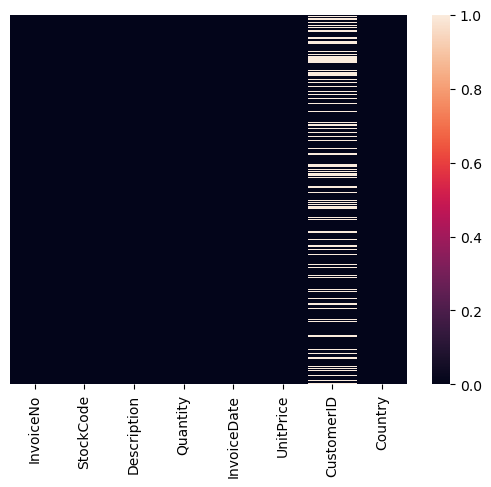

In [12]:
sns.heatmap(customer.isnull(), yticklabels= False)

Records with negative quantity

In [14]:
neg_ft = [ft for ft in num_ft if (customer[ft] < 0).any()]
for ft in neg_ft:
    sum_cust = len(customer[customer[ft] < 0])
    print(f"There are {sum_cust} negative quantities for feature '{ft}'")

There are 10624 negative quantities for feature 'Quantity'
There are 2 negative quantities for feature 'UnitPrice'


Inspecting the rows of negative quantities

In [15]:
customer[customer["Quantity"]<0].head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice  CustomerID         Country  
141 2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154 2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235 2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237 2010-12-01 10:24:00       0.29     17548.0  United Kingdom

In [16]:
customer[customer["UnitPrice"]<0].head()

InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

The 'C' in the invoiceNo indicates the order was cancelled 

In [17]:
return_order = customer[customer['Quantity'] < 0]
print("There are ", round(len(return_order)/len(customer),2)*100, "% negative quantities which imply that these orders were either cancelled or returned")

There are  2.0 % negative quantities which imply that these orders were either cancelled or returned


In [19]:
customer['InvoiceNo']= customer['InvoiceNo'].astype("str")
customer[customer['InvoiceNo'].str.match("^\\d{6}$")==False]

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country  
141    2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154    2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235    2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236    2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237    2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
...                    ...        ...         ...             ...  
540449 2011-12-09 09:57:00       0.83     14397.0  United Kingdom  
541541 2011-12-09 10:28:00     224.69     15498.0  United Kingdom  
541715 2011-12-09 11:57:00      10.95     15311.0  United Kingdom  
541716 2011-12-09 11:58:00       1.25     17315.0  United Kingdom  
541717 2011-12-09 11:58:00       1.25     17315.0  United Kingdom  

[9291 rows x 8 columns]

In [33]:
customer[
    (customer['InvoiceNo'].str.startswith('53')) &
    (customer['CustomerID'] == 14527.0)
]


InvoiceNo StockCode                        Description  Quantity  \
8963     537159     22112         CHOCOLATE HOT WATER BOTTLE         6   
8964     537159     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
8965     537159     21479      WHITE SKULL HOT WATER BOTTLE          1   
8966     537159     22114  HOT WATER BOTTLE TEA AND SYMPATHY         6   
8967     537159    35598B          BLACK CHRISTMAS TREE 60CM         1   
...         ...       ...                                ...       ...   
38604    539588     21539          RED RETROSPOT BUTTER DISH         1   
38605    539588     22607        WOODEN ROUNDERS GARDEN SET          1   
38606    539588    85099B            JUMBO BAG RED RETROSPOT         2   
38607    539588     21844                  RED RETROSPOT MUG         1   
38608    539588     21259        VICTORIAN SEWING BOX SMALL          2   

              InvoiceDate  UnitPrice  CustomerID         Country  
8963  2010-12-05 13:17:00       4.95     14527.0  United Kingdom  
8964  2010-12-05 13:17:00       4.95     14527.0  United Kingdom  
8965  2010-12-05 13:17:00       3.75     14527.0  United Kingdom  
8966  2010-12-05 13:17:00       3.95     14527.0  United Kingdom  
8967  2010-12-05 13:17:00       2.95     14527.0  United Kingdom  
...                   ...        ...         ...             ...  
38604 2010-12-20 13:11:00       4.95     14527.0  United Kingdom  
38605 2010-12-20 13:11:00       9.95     14527.0  United Kingdom  
38606 2010-12-20 13:11:00       1.95     14527.0  United Kingdom  
38607 2010-12-20 13:11:00       2.95     14527.0  United Kingdom  
38608 2010-12-20 13:11:00       5.95     14527.0  United Kingdom  

[105 rows x 8 columns]

In [18]:
customer['InvoiceNo'].str.replace("[0-9]", "", regex=True).unique()

array(['', 'C', 'A'], dtype=object)

In [19]:
customer[customer["InvoiceNo"].str.startswith("A")]

InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299982   A563185         B  Adjust bad debt         1 2011-08-12 14:50:00   
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299982   11062.06         NaN  United Kingdom  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

Verify if the stockcodes are valid (5 digit unique codes)

In [20]:
customer["StockCode"]= customer["StockCode"].astype("str")
customer[(customer['StockCode'].str.match("^\\d{5}$")==False) & (customer['StockCode'].str.match("^\\d{5}[a-zA-z]+$")==False)]["StockCode"].unique()

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

Only 'PADS' seem legitimate

In [21]:
customer[customer["CustomerID"]==12346.0]

InvoiceNo StockCode                     Description  Quantity  \
61619    541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624   C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   

              InvoiceDate  UnitPrice  CustomerID         Country  
61619 2011-01-18 10:01:00       1.04     12346.0  United Kingdom  
61624 2011-01-18 10:17:00       1.04     12346.0  United Kingdom

**CLEANING THE DATASET**

In [150]:
#dropping null values
clean_df = customer.copy()
clean_df.dropna(subset=["CustomerID"], inplace=True)

In [144]:
clean_df["CustomerID"] = clean_df["CustomerID"].astype("str")
clean_df["InvoiceNo"] = clean_df["InvoiceNo"].astype("str")
clean_df['CustomerID'] = clean_df['CustomerID'].astype(str).str.split('.').str[0]

In [111]:
customer.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

Removing Dupilcates

In [145]:
duplicates = clean_df[clean_df.duplicated(keep=False)]
duplicate_rows_sorted = duplicates.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])
duplicate_rows_sorted.head()

InvoiceNo StockCode                    Description  Quantity  \
494    536409     21866    UNION JACK FLAG LUGGAGE TAG         1   
517    536409     21866    UNION JACK FLAG LUGGAGE TAG         1   
485    536409     22111   SCOTTIE DOG HOT WATER BOTTLE         1   
539    536409     22111   SCOTTIE DOG HOT WATER BOTTLE         1   
489    536409     22866  HAND WARMER SCOTTY DOG DESIGN         1   

            InvoiceDate  UnitPrice CustomerID         Country  
494 2010-12-01 11:45:00       1.25      17908  United Kingdom  
517 2010-12-01 11:45:00       1.25      17908  United Kingdom  
485 2010-12-01 11:45:00       4.95      17908  United Kingdom  
539 2010-12-01 11:45:00       4.95      17908  United Kingdom  
489 2010-12-01 11:45:00       2.10      17908  United Kingdom

In [113]:
# Displaying the number of duplicate rows
print(f"The dataset contains {clean_df.duplicated().sum()} duplicate rows that need to be eliminated.")

The dataset contains 5225 duplicate rows that need to be eliminated.


In [146]:
#Eliminating duplicates
clean_df = clean_df.drop_duplicates()

In [115]:
print("We dropped", (1-(len(clean_df)/len(customer)))*100, "%", "of data to extract useful data")

We dropped 25.89087835780546 % of data to extract useful data


In [151]:
cancel =clean_df['Quantity'] < 0
cancelled_order = clean_df[cancel]

In [148]:
clean_df = clean_df[~cancel]

In [153]:
cancelled_order.head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice  CustomerID         Country  
141 2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154 2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235 2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237 2010-12-01 10:24:00       0.29     17548.0  United Kingdom

In [142]:
 cancelled_order[(cancelled_order['StockCode']=='PADS')]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

In [138]:
 clean_df[(clean_df['StockCode'].str.match("^\\d{5}$")==False) & (clean_df['StockCode'].str.match("^\\d{5}[a-zA-z]+$")==False)]["StockCode"].unique()

array([], dtype=object)

In [155]:
discarded_orders =  cancelled_order[(cancelled_order['StockCode'].str.match("^\\d{5}$")==False) &
                                    (cancelled_order['StockCode'].str.match("^\\d{5}[a-zA-z]+$")==False)]
discarded_orders.head(20)

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
141     C536379         D    Discount        -1 2010-12-01 09:41:00   
9038    C537164         D    Discount        -1 2010-12-05 13:21:00   
13052   C537414      POST     POSTAGE        -1 2010-12-06 15:09:00   
14498   C537597         D    Discount        -1 2010-12-07 12:34:00   
19392   C537857         D    Discount        -1 2010-12-08 16:00:00   
21758   C538124         M      Manual        -4 2010-12-09 15:43:00   
29530   C538806         M      Manual        -1 2010-12-14 11:59:00   
31134   C538897         D    Discount        -1 2010-12-15 09:14:00   
31135   C538897         D    Discount        -1 2010-12-15 09:14:00   
31663   C539003         D    Discount        -1 2010-12-15 12:35:00   
32383   C539063      POST     POSTAGE        -1 2010-12-15 16:50:00   
32402   C539073      POST     POSTAGE        -1 2010-12-15 17:08:00   
34591   C539409      POST     POSTAGE        -1 2010-12-17 12:58:00   
38609   C539589         D    Discount        -1 2010-12-20 13:14:00   
39905   C539712      POST     POSTAGE        -1 2010-12-21 12:40:00   
43448   C540057      POST     POSTAGE        -1 2011-01-04 14:29:00   
44302   C540164        C2    CARRIAGE        -1 2011-01-05 12:02:00   
44405   C540171         D    Discount        -1 2011-01-05 12:26:00   
45622   C540271         M      Manual        -1 2011-01-06 11:51:00   
45913   C540307         M      Manual        -2 2011-01-06 12:58:00   

       UnitPrice  CustomerID         Country  
141        27.50     14527.0  United Kingdom  
9038       29.29     14527.0  United Kingdom  
13052       4.41     16861.0  United Kingdom  
14498     281.00     15498.0  United Kingdom  
19392     267.12     17340.0  United Kingdom  
21758       0.50     15329.0  United Kingdom  
29530       4.25     15181.0  United Kingdom  
31134       5.76     16422.0  United Kingdom  
31135      42.50     16422.0  United Kingdom  
31663      26.93     14527.0  United Kingdom  
32383      12.34     15107.0  United Kingdom  
32402       3.50     12971.0  United Kingdom  
34591      18.00     12720.0         Germany  
38609      13.88     14527.0  United Kingdom  
39905       5.75     15602.0  United Kingdom  
43448      40.00     12483.0          Sweden  
44302      50.00     14911.0            EIRE  
44405      22.97     14527.0  United Kingdom  
45622    1126.00     12503.0           Spain  
45913      21.95     15823.0  United Kingdom

In [156]:
len(clean_df)

406829

In [157]:
len(discarded_orders)

366

In [158]:
clean_df = clean_df.merge(discarded_orders, how='left', indicator=True)
clean_df = clean_df[clean_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [159]:
len(clean_df)

406463

In [36]:
cancelled_order[cancelled_order['StockCode']=='M']

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
21758    C538124         M      Manual        -4 2010-12-09 15:43:00   
29530    C538806         M      Manual        -1 2010-12-14 11:59:00   
45622    C540271         M      Manual        -1 2011-01-06 11:51:00   
45913    C540307         M      Manual        -2 2011-01-06 12:58:00   
59410    C541284         M      Manual       -36 2011-01-17 12:45:00   
...          ...       ...         ...       ...                 ...   
520134   C580263         M      Manual       -16 2011-12-02 12:43:00   
523375   C580510         M      Manual        -1 2011-12-04 13:48:00   
533082   C581009         M      Manual        -1 2011-12-07 09:15:00   
534308   C581145         M      Manual        -1 2011-12-07 13:48:00   
541541   C581499         M      Manual        -1 2011-12-09 10:28:00   

        UnitPrice  CustomerID         Country  
21758        0.50     15329.0  United Kingdom  
29530        4.25     15181.0  United Kingdom  
45622     1126.00     12503.0           Spain  
45913       21.95     15823.0  United Kingdom  
59410        0.87     17744.0  United Kingdom  
...           ...         ...             ...  
520134       0.29     12536.0          France  
523375       1.25     14456.0  United Kingdom  
533082     125.00     16971.0  United Kingdom  
534308       9.95     17490.0  United Kingdom  
541541     224.69     15498.0  United Kingdom  

[175 rows x 8 columns]

In [24]:
# # merged[(merged["IsCanceled"]==True) &(merged["IsCanceled_b"]==False) & (merged["CustomerID"]=="12346")]
# merged[merged["CustomerID"]=="12346"]

InvoiceNo StockCode                     Description  Quantity  \
106303    541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
106304    541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
106323   C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   
106324   C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   

               InvoiceDate  UnitPrice CustomerID         Country  IsCanceled  \
106303 2011-01-18 10:01:00       1.04      12346  United Kingdom       False   
106304 2011-01-18 10:01:00       1.04      12346  United Kingdom       False   
106323 2011-01-18 10:17:00       1.04      12346  United Kingdom        True   
106324 2011-01-18 10:17:00       1.04      12346  United Kingdom        True   

       InvoiceNo_b                   Description_b  Quantity_b  \
106303      541431  MEDIUM CERAMIC TOP STORAGE JAR       74215   
106304     C541433  MEDIUM CERAMIC TOP STORAGE JAR      -74215   
106323      541431  MEDIUM CERAMIC TOP STORAGE JAR       74215   
106324     C541433  MEDIUM CERAMIC TOP STORAGE JAR      -74215   

             InvoiceDate_b  UnitPrice_b       Country_b  IsCanceled_b  
106303 2011-01-18 10:01:00         1.04  United Kingdom         False  
106304 2011-01-18 10:17:00         1.04  United Kingdom          True  
106323 2011-01-18 10:01:00         1.04  United Kingdom         False  
106324 2011-01-18 10:17:00         1.04  United Kingdom          True

In [42]:
clean_df[
    (clean_df['InvoiceNo'].str.startswith('53')) &
    (clean_df['CustomerID'] == 14527.0)
]


InvoiceNo StockCode                        Description  Quantity  \
8963     537159     22112         CHOCOLATE HOT WATER BOTTLE         6   
8964     537159     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
8965     537159     21479      WHITE SKULL HOT WATER BOTTLE          1   
8966     537159     22114  HOT WATER BOTTLE TEA AND SYMPATHY         6   
8967     537159    35598B          BLACK CHRISTMAS TREE 60CM         1   
...         ...       ...                                ...       ...   
38604    539588     21539          RED RETROSPOT BUTTER DISH         1   
38605    539588     22607        WOODEN ROUNDERS GARDEN SET          1   
38606    539588    85099B            JUMBO BAG RED RETROSPOT         2   
38607    539588     21844                  RED RETROSPOT MUG         1   
38608    539588     21259        VICTORIAN SEWING BOX SMALL          2   

              InvoiceDate  UnitPrice  CustomerID         Country  
8963  2010-12-05 13:17:00       4.95     14527.0  United Kingdom  
8964  2010-12-05 13:17:00       4.95     14527.0  United Kingdom  
8965  2010-12-05 13:17:00       3.75     14527.0  United Kingdom  
8966  2010-12-05 13:17:00       3.95     14527.0  United Kingdom  
8967  2010-12-05 13:17:00       2.95     14527.0  United Kingdom  
...                   ...        ...         ...             ...  
38604 2010-12-20 13:11:00       4.95     14527.0  United Kingdom  
38605 2010-12-20 13:11:00       9.95     14527.0  United Kingdom  
38606 2010-12-20 13:11:00       1.95     14527.0  United Kingdom  
38607 2010-12-20 13:11:00       2.95     14527.0  United Kingdom  
38608 2010-12-20 13:11:00       5.95     14527.0  United Kingdom  

[105 rows x 8 columns]

In [55]:
clean_df[
#     (clean_df['InvoiceNo'].str.startswith('54')) &
    (clean_df['CustomerID'] == 14527.0) &
    (clean_df['StockCode']=='22469')
]


InvoiceNo StockCode            Description  Quantity  \
20174     538012     22469  HEART OF WICKER SMALL         2   
149291   C549288     22469  HEART OF WICKER SMALL        -1   
367212    568875     22469  HEART OF WICKER SMALL         1   

               InvoiceDate  UnitPrice  CustomerID         Country  
20174  2010-12-09 12:32:00       1.65     14527.0  United Kingdom  
149291 2011-04-07 18:06:00       1.65     14527.0  United Kingdom  
367212 2011-09-29 12:23:00       1.65     14527.0  United Kingdom

Remove other transactions that were canceled

In [86]:
clean_df = clean_df[
    clean_df["InvoiceNo"].str.match(r"^\d{6}$")  # 6-digit invoices
        
]
clean_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  IsCanceled  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom       False  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom       False  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom       False  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom       False  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom       False

In [93]:
#items with proper StockCode 
returned_items = cancelled_order[(cancelled_order['StockCode'].str.match("^\\d{5}$")) | (cancelled_order['StockCode'].str.match("^\\d{5}[a-zA-z]+$"))]
returned_items.head()

InvoiceNo StockCode                        Description  Quantity  \
154   C536383    35004C    SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556     PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984   PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983   PACK OF 12 BLUE PAISLEY TISSUES        -24   
238   C536391     21980  PACK OF 12 RED RETROSPOT TISSUES        -24   

            InvoiceDate  UnitPrice CustomerID         Country  IsCanceled  
154 2010-12-01 09:49:00       4.65      15311  United Kingdom        True  
235 2010-12-01 10:24:00       1.65      17548  United Kingdom        True  
236 2010-12-01 10:24:00       0.29      17548  United Kingdom        True  
237 2010-12-01 10:24:00       0.29      17548  United Kingdom        True  
238 2010-12-01 10:24:00       0.29      17548  United Kingdom        True

In [161]:
#items with proper StockCode 
clean_df = clean_df[(clean_df['StockCode'].str.match("^\\d{5}$")) | (clean_df['StockCode'].str.match("^\\d{5}[a-zA-z]+$"))]
clean_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [166]:
clean_df[clean_df['StockCode']=='M']

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

In [90]:
clean_df=  clean_df[clean_df["UnitPrice"]>0]

In [49]:
customer_df[customer_df["InvoiceNo"].str.startswith("C")] # cancellation invoices

InvoiceNo StockCode                        Description  Quantity  \
392732   C536383    35004C    SET OF 3 COLOURED  FLYING DUCKS        -1   
392733   C536391     22556     PLASTERS IN TIN CIRCUS PARADE        -12   
392734   C536391     21984   PACK OF 12 PINK PAISLEY TISSUES        -24   
392735   C536391     21983   PACK OF 12 BLUE PAISLEY TISSUES        -24   
392736   C536391     21980  PACK OF 12 RED RETROSPOT TISSUES        -24   
...          ...       ...                                ...       ...   
401233   C581490     22178    VICTORIAN GLASS HANGING T-LIGHT       -12   
401234   C581490     23144    ZINC T-LIGHT HOLDER STARS SMALL       -11   
401235   C581568     21258         VICTORIAN SEWING BOX LARGE        -5   
401236   C581569     84978   HANGING HEART JAR T-LIGHT HOLDER        -1   
401237   C581569     20979      36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country  
392732 2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
392733 2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
392734 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
392735 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
392736 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
...                    ...        ...         ...             ...  
401233 2011-12-09 09:57:00       1.95     14397.0  United Kingdom  
401234 2011-12-09 09:57:00       0.83     14397.0  United Kingdom  
401235 2011-12-09 11:57:00      10.95     15311.0  United Kingdom  
401236 2011-12-09 11:58:00       1.25     17315.0  United Kingdom  
401237 2011-12-09 11:58:00       1.25     17315.0  United Kingdom  

[8506 rows x 8 columns]

In [40]:
clean_df[
    clean_df["InvoiceNo"].str.match(r"^\d{6}$") |  # 6-digit invoices
     clean_df["InvoiceNo"].str.startswith("C")     # cancellation invoices
]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

In [130]:
clean_df["StockCode"] = clean_df["StockCode"].astype("str")
filter = (
    (clean_df["StockCode"].str.match("^\\d{5}$")==True)
    | (clean_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$")==True)
    | (clean_df["StockCode"].str.match("^PADS$")==False)
)

clean_df = clean_df[filter]
clean_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

In [131]:
clean_df[clean_df["StockCode"]=='PADS']

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

In [102]:
customer_df = pd.concat([clean_df, returned_items], ignore_index=True)
customer_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  IsCanceled  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom       False  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom       False  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom       False  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom       False  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom       False

In [101]:
len(clean_df)

391153

In [64]:
len(clean_df)

401604

In [168]:
free_items = clean_df[clean_df["UnitPrice"]==0]
len(free_items)

33

In [169]:
clean_df = clean_df[clean_df["UnitPrice"]>0]

Items with unit price=0 might be free items that are not really important for RFM analysis

In [68]:
clean_df.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  401564.000000                         401564  401564.000000   
mean       12.149911  2011-07-10 12:06:07.514567936       3.474410   
min    -80995.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-06 15:02:00       1.250000   
50%         5.000000            2011-07-29 15:32:30       1.950000   
75%        12.000000            2011-10-20 11:58:00       3.750000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       249.512649                            NaN      69.767501   

          CustomerID  
count  401564.000000  
mean    15281.266797  
min     12346.000000  
25%     13939.000000  
50%     15145.000000  
75%     16788.000000  
max     18287.000000  
std      1713.978947

In [167]:
clean_df[clean_df["UnitPrice"]== clean_df["UnitPrice"].min()]

InvoiceNo StockCode                          Description  Quantity  \
7012      537197     22841         ROUND CAKE TIN VINTAGE GREEN         1   
23071     539263     22580         ADVENT CALENDAR GINGHAM SACK         4   
26046     539722     22423             REGENCY CAKESTAND 3 TIER        10   
29881     540372     22090              PAPER BUNTING RETROSPOT        24   
29883     540372     22553               PLASTERS IN TIN SKULLS        24   
35460     541109     22168        ORGANISER WOOD ANTIQUE WHITE          1   
55279     543599    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        16   
87903     547417     22062  CERAMIC BOWL WITH LOVE HEART DESIGN        36   
95201     548318     22055   MINI CAKE STAND  HANGING STRAWBERY         5   
99945     548871     22162          HEART GARLAND RUSTIC PADDED         2   
109968    550188     22636   CHILDS BREAKFAST SET CIRCUS PARADE         1   
131865    553000     47566                        PARTY BUNTING         4   
140517    554037     22619            SET OF 6 SOLDIER SKITTLES        80   
199499    561284     22167           OVAL WALL MIRROR DIAMANTE          1   
202073    561669     22960             JAM MAKING SET WITH JARS        11   
214132    562973     23157           SET OF 6 NATIVITY MAGNETS        240   
229359    564651     23270     SET OF 2 CERAMIC PAINTED HEARTS         96   
229360    564651     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER       192   
229361    564651     22955             36 FOIL STAR CAKE CASES        144   
229362    564651     21786                   POLKADOT RAIN HAT        144   
280386    569716     22778                   GLASS CLOCHE SMALL         2   
314491    572893     21208          PASTEL COLOUR HONEYCOMB FAN         5   
327463    574138     23234        BISCUIT TIN VINTAGE CHRISTMAS       216   
327630    574175     22065       CHRISTMAS PUDDING TRINKET POT         12   
329894    574469     22385            JUMBO BAG SPACEBOY DESIGN        12   
336106    574879     22625                   RED KITCHEN SCALES         2   
336738    574920     22899         CHILDREN'S APRON DOLLY GIRL          1   
336739    574920     23480       MINI LIGHTS WOODLAND MUSHROOMS         1   
342114    575579     22437        SET OF 9 BLACK SKULL BALLOONS        20   
342115    575579     22089        PAPER BUNTING VINTAGE PAISLEY        24   
360854    577129     22464          HANGING METAL HEART LANTERN         4   
362308    577314     23407       SET OF 2 TRAYS HOME SWEET HOME         2   
378894    578841     84826       ASSTD DESIGN 3D PAPER STICKERS     12540   

               InvoiceDate  UnitPrice  CustomerID         Country  
7012   2010-12-05 14:02:00        0.0     12647.0         Germany  
23071  2010-12-16 14:36:00        0.0     16560.0  United Kingdom  
26046  2010-12-21 13:45:00        0.0     14911.0            EIRE  
29881  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
29883  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
35460  2011-01-13 15:10:00        0.0     15107.0  United Kingdom  
55279  2011-02-10 13:08:00        0.0     17560.0  United Kingdom  
87903  2011-03-23 10:25:00        0.0     13239.0  United Kingdom  
95201  2011-03-30 12:45:00        0.0     13113.0  United Kingdom  
99945  2011-04-04 14:42:00        0.0     14410.0  United Kingdom  
109968 2011-04-14 18:57:00        0.0     12457.0     Switzerland  
131865 2011-05-12 15:21:00        0.0     17667.0  United Kingdom  
140517 2011-05-20 14:13:00        0.0     12415.0       Australia  
199499 2011-07-26 12:24:00        0.0     16818.0  United Kingdom  
202073 2011-07-28 17:09:00        0.0     12507.0           Spain  
214132 2011-08-11 11:42:00        0.0     14911.0            EIRE  
229359 2011-08-26 14:19:00        0.0     14646.0     Netherlands  
229360 2011-08-26 14:19:00        0.0     14646.0     Netherlands  
229361 2011-08-26 14:19:00        0.0     14646.0     Netherlands  
229362 2011-08-26 14:19:00  

1.3 Time period covered by the dataset

In [38]:
clean_df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [39]:
clean_df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [40]:
time_period= (clean_df['InvoiceDate'].max() - clean_df['InvoiceDate'].min()).days
print("The time period covered by the dataset is:", time_period, "days")

The time period covered by the dataset is: 373 days


**2. CUSTOMER ANALYSIS**

2.1 Unique Customers present in the data

In [170]:
cust_no =len(clean_df['CustomerID'].unique())
print("Total number of unique customers are:", cust_no)

Total number of unique customers are: 4362


In [51]:
cust_no =len(customer_df['CustomerID'].unique())
print("Total number of unique customers are:", cust_no)

Total number of unique customers are: 4365


**FEATURE ENGINEERING**

In [171]:
clean_df['SalesTotal'] = clean_df['UnitPrice']*clean_df['Quantity']
clean_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  SalesTotal  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34

In [192]:
clean_df['SalesTotal'] = clean_df['UnitPrice']*clean_df['Quantity']

# Assuming your DataFrame is called df
grouped = clean_df.groupby(['CustomerID', 'InvoiceNo', 'StockCode', 'UnitPrice']).agg({
    'Quantity': 'sum',
    'SalesTotal': 'sum',
    'Description': 'first',  # optional: keep first description per group
    'Country': 'first',      # optional: keep first country per group     
    'InvoiceDate' :  'max'
}).reset_index()

grouped.head()

CustomerID InvoiceNo StockCode  UnitPrice  Quantity  SalesTotal  \
0     12346.0    541431     23166       1.04     74215    77183.60   
1     12346.0   C541433     23166       1.04    -74215   -77183.60   
2     12347.0    537626     20780       4.65        12       55.80   
3     12347.0    537626     20782       5.49         6       32.94   
4     12347.0    537626     21064       5.95         6       35.70   

                      Description         Country         InvoiceDate  
0  MEDIUM CERAMIC TOP STORAGE JAR  United Kingdom 2011-01-18 10:01:00  
1  MEDIUM CERAMIC TOP STORAGE JAR  United Kingdom 2011-01-18 10:17:00  
2       BLACK EAR MUFF HEADPHONES         Iceland 2010-12-07 14:57:00  
3  CAMOUFLAGE EAR MUFF HEADPHONES         Iceland 2010-12-07 14:57:00  
4           BOOM BOX SPEAKER BOYS         Iceland 2010-12-07 14:57:00

In [182]:
clean_df[(clean_df['StockCode']=='85019C') & (clean_df['CustomerID']==14460.0) ]

InvoiceNo StockCode                   Description  Quantity  \
50280   C542991    85019C  CURIOUS  IMAGES NOTEBOOK SET       -12   
50281    542992    85019C  CURIOUS  IMAGES NOTEBOOK SET        24   

              InvoiceDate  UnitPrice  CustomerID         Country  SalesTotal  
50280 2011-02-02 11:54:00       4.25     14460.0  United Kingdom       -51.0  
50281 2011-02-02 11:55:00       1.25     14460.0  United Kingdom        30.0

In [191]:
grouped.describe()

CustomerID      UnitPrice       Quantity     SalesTotal
count  394870.000000  394870.000000  394870.000000  394870.000000
mean    15282.977942       2.919683      12.378428      20.985801
std      1711.090139       4.473496     251.636559     428.129972
min     12346.000000       0.030000  -80995.000000 -168469.600000
25%     13950.000000       1.250000       2.000000       4.920000
50%     15146.000000       1.950000       6.000000      11.900000
75%     16782.000000       3.750000      12.000000      19.800000
max     18287.000000     649.500000   80995.000000  168469.600000

**## RFM CALCULATION**

In [205]:
rfm_df = grouped.groupby("CustomerID", as_index=False) \
    .agg(
        Frequency=("InvoiceNo", "nunique"),
        Monetary=("SalesTotal", "sum"),
        LastInvoiceDt =("InvoiceDate", "max"),
    )
rfm_df= rfm_df[rfm_df['Monetary']>0.5]
rfm_df= rfm_df[rfm_df['Frequency']>0]
rfm_df.head()

CustomerID  Frequency  Monetary       LastInvoiceDt
1    12347.00          7   4310.00 2011-12-07 15:52:00
2    12348.00          4   1437.24 2011-09-25 13:13:00
3    12349.00          1   1457.55 2011-11-21 09:51:00
4    12350.00          1    294.40 2011-02-02 16:01:00
5    12352.00          8   1265.41 2011-11-03 14:37:00

In [206]:
pd.set_option('display.float_format', '{:.2f}'.format)
rfm_df.describe()

CustomerID  Frequency  Monetary                  LastInvoiceDt
count     4320.00    4320.00   4320.00                           4320
mean     15300.77       5.03   1919.17  2011-09-10 07:36:15.249999872
min      12347.00       1.00      2.90            2010-12-01 09:53:00
25%      13815.75       1.00    300.50            2011-07-23 23:57:15
50%      15299.50       3.00    653.99            2011-10-21 11:00:30
75%      16778.25       5.00   1611.43            2011-11-23 11:04:45
max      18287.00     242.00 278778.02            2011-12-09 12:50:00
std       1720.22       9.12   8303.91                            NaN

**RECENCY**

In [207]:
max_date = rfm_df['LastInvoiceDt'].max()
# Calculate Recency (number of days since the most recent purchase)
rfm_df['Recency'] = (max_date - rfm_df['LastInvoiceDt']).dt.days

rfm_df.head()


CustomerID  Frequency  Monetary       LastInvoiceDt  Recency
1    12347.00          7   4310.00 2011-12-07 15:52:00        1
2    12348.00          4   1437.24 2011-09-25 13:13:00       74
3    12349.00          1   1457.55 2011-11-21 09:51:00       18
4    12350.00          1    294.40 2011-02-02 16:01:00      309
5    12352.00          8   1265.41 2011-11-03 14:37:00       35

In [208]:
rfm_df= rfm_df[["CustomerID", "Recency", "Frequency", "Monetary", "LastInvoiceDt"]]

In [209]:
rfm_df.describe()

CustomerID  Recency  Frequency  Monetary                  LastInvoiceDt
count     4320.00  4320.00    4320.00   4320.00                           4320
mean     15300.77    89.70       5.03   1919.17  2011-09-10 07:36:15.249999872
min      12347.00     0.00       1.00      2.90            2010-12-01 09:53:00
25%      13815.75    16.00       1.00    300.50            2011-07-23 23:57:15
50%      15299.50    49.00       3.00    653.99            2011-10-21 11:00:30
75%      16778.25   138.25       5.00   1611.43            2011-11-23 11:04:45
max      18287.00   373.00     242.00 278778.02            2011-12-09 12:50:00
std       1720.22    99.42       9.12   8303.91                            NaN

In [210]:
rfm_df[rfm_df['Monetary']==278778.02]

CustomerID  Recency  Frequency  Monetary       LastInvoiceDt
1699    14646.00        1         73 278778.02 2011-12-08 12:12:00

C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


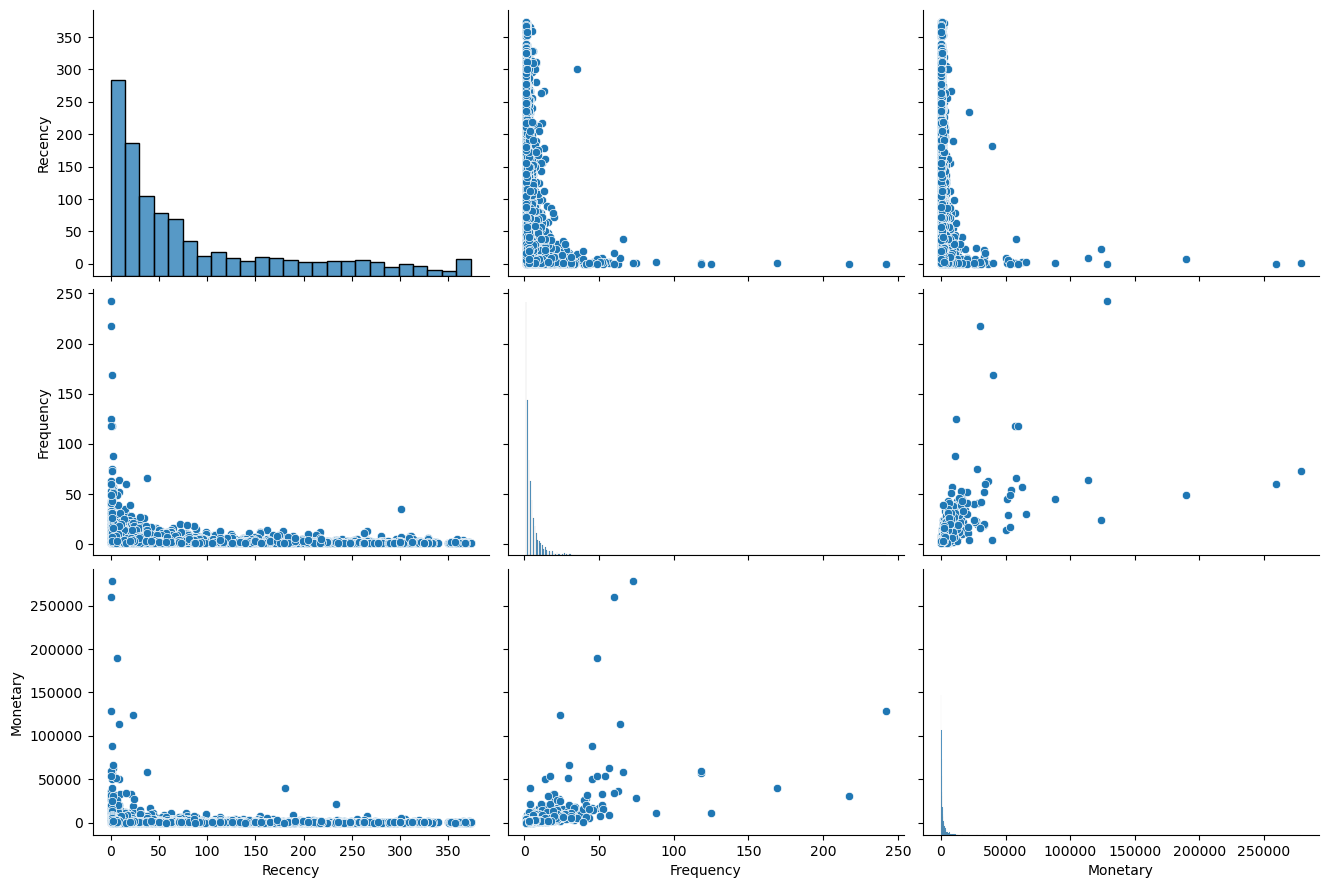

In [211]:
columns = ['Recency', 'Frequency', 'Monetary']
sns.pairplot(rfm_df[columns], height=3, aspect=1.5)

C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


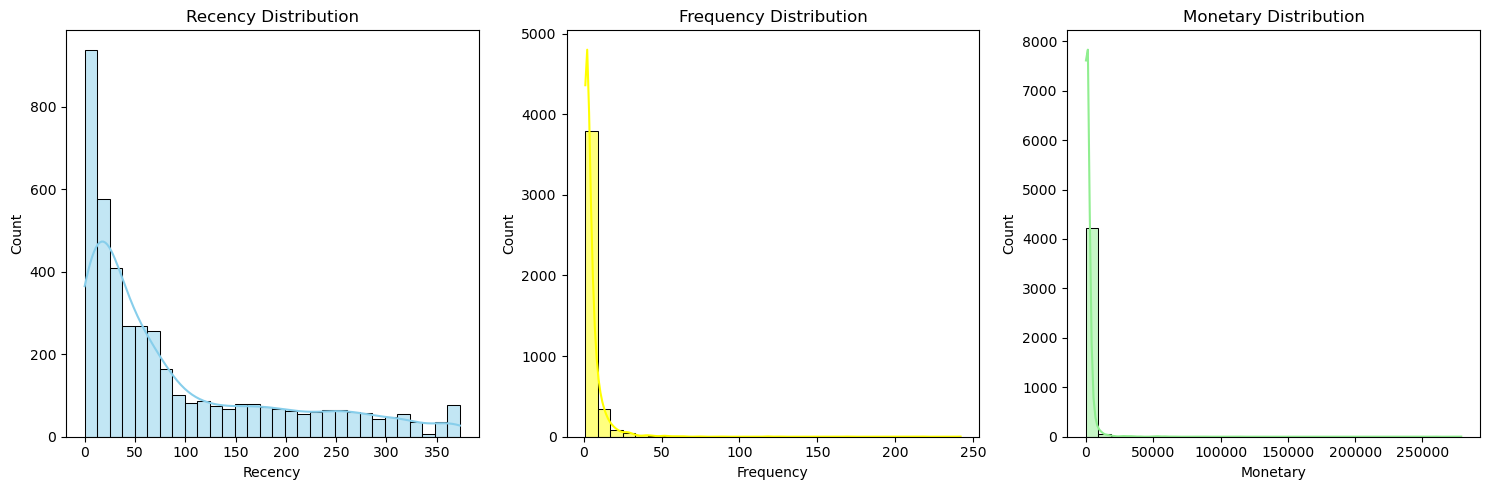

In [213]:
plt.figure(figsize=(15, 5))

# Recency distribution
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], bins=30, color='skyblue', kde=True)
plt.title('Recency Distribution')

# Frequency distribution
plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], bins=30, color='yellow', kde=True)
plt.title('Frequency Distribution')

# Monetary distribution
plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], bins=30, color='lightgreen', kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

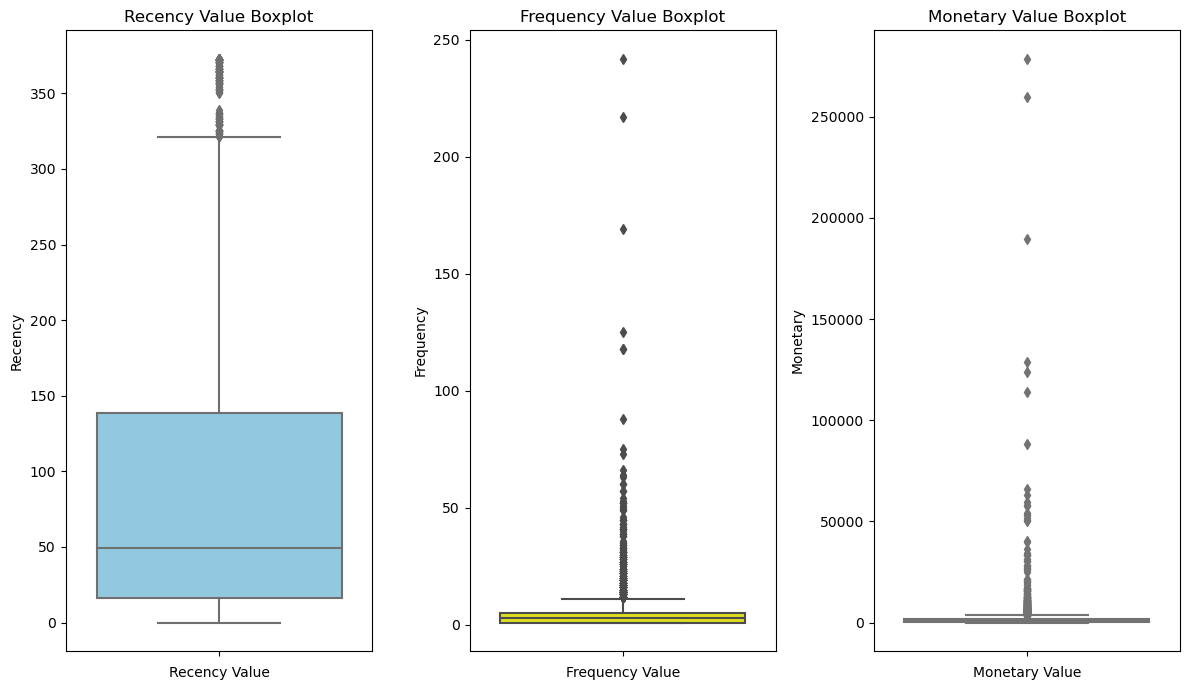

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

plt.subplot(1, 3, 1)
sns.boxplot(y=rfm_df['Recency'], color='skyblue')
plt.title('Recency Value Boxplot')
plt.xlabel('Recency Value')

plt.subplot(1, 3, 2)
sns.boxplot(y=rfm_df['Frequency'], color='yellow')
plt.title('Frequency Value Boxplot')
plt.xlabel('Frequency Value')

plt.subplot(1, 3, 3)
sns.boxplot(y=rfm_df['Monetary'], color='lightgreen')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.tight_layout()
plt.show()


In [215]:
# monetary_mean = rfm_df['Monetary'].mean()
# vip_customers = rfm_df[rfm_df['Monetary'] > 10 * monetary_mean].copy()
# regular_customers = rfm_df[rfm_df['Monetary'] <= 10 * monetary_mean].copy()


In [219]:
# Step 1: Calculate IQR bounds for 'Monetary'
M_Q1 = rfm_df['Monetary'].quantile(0.25)  # 25th percentile
M_Q3 = rfm_df['Monetary'].quantile(0.75)  # 75th percentile
M_IQR = M_Q3 - M_Q1                       # Interquartile Range

lower_m = max(0, M_Q1 - 1.5 * M_IQR)      # Lower bound (avoid negatives)
upper_m = M_Q3 + 1.5 * M_IQR              # Upper bound

# Step 2: Filter outliers and regular customers based on IQR
vip_customers = rfm_df[rfm_df['Monetary'] > upper_m].copy()
regular_customers = rfm_df[rfm_df['Monetary'] <= upper_m].copy()


In [220]:
regular_customers.describe()

CustomerID  Recency  Frequency  Monetary                  LastInvoiceDt
count     3909.00  3909.00    3909.00   3909.00                           3909
mean     15329.18    96.84       3.41    866.66  2011-09-03 04:03:18.541826304
min      12348.00     0.00       1.00      2.90            2010-12-01 09:53:00
25%      13859.00    20.00       1.00    274.51            2011-07-07 10:40:00
50%      15342.00    56.00       2.00    574.68            2011-10-14 11:42:00
75%      16801.00   155.00       4.00   1208.51            2011-11-18 17:11:00
max      18287.00   373.00      39.00   3563.85            2011-12-09 12:50:00
std       1709.08   101.07       3.15    810.79                            NaN

In [223]:
#define clusters within the vip customers for monetary
vip_customers[vip_customers['Monetary']>10000.00]

CustomerID  Recency  Frequency  Monetary       LastInvoiceDt
50      12409.00       78          7  11056.93 2011-09-22 10:38:00
55      12415.00       23         24 123638.18 2011-11-15 14:22:00
71      12433.00        0          7  13375.87 2011-12-09 10:02:00
100     12471.00        1         45  16358.92 2011-12-07 15:43:00
106     12477.00       22          9  13117.01 2011-11-17 09:51:00
...          ...      ...        ...       ...                 ...
4033    17841.00        1        169  40333.22 2011-12-08 12:07:00
4043    17857.00        2         24  25185.84 2011-12-06 13:41:00
4051    17865.00       30         27  10156.44 2011-11-09 12:08:00
4115    17949.00        0         49  53215.74 2011-12-08 18:46:00
4223    18102.00        0         60 259657.30 2011-12-09 11:50:00

[97 rows x 5 columns]

In [224]:
F_Q1 = rfm_df['Frequency'].quantile(0.25)
F_Q3 = rfm_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1
lower_f = max(0, F_Q1 - 1.5 * F_IQR)  # Ensures lower bound is not negative
upper_f = F_Q3 + 1.5 * F_IQR
frequency_outliers_df = rfm_df[(rfm_df['Frequency'] > upper_f) | (rfm_df['Frequency'] <lower_f)].copy()

frequency_outliers_df.describe()

CustomerID  Recency  Frequency  Monetary                  LastInvoiceDt
count      387.00   387.00     387.00    387.00                            387
mean     15225.73    15.40      23.53  11226.82  2011-11-23 16:02:55.348837120
min      12362.00     0.00      12.00    590.30            2011-02-10 14:38:00
25%      13826.00     2.00      14.00   3161.77            2011-11-21 23:30:00
50%      15078.00     7.00      17.00   5040.00            2011-12-01 14:14:00
75%      16725.50    17.50      25.50   8647.27            2011-12-07 09:28:00
max      18283.00   301.00     242.00 278778.02            2011-12-09 12:49:00
std       1735.85    30.54      22.12  25583.02                            NaN

In [225]:
non_outliers_df = rfm_df[(~rfm_df.index.isin(vip_customers.index)) & (~rfm_df.index.isin(frequency_outliers_df.index))]
non_outliers_df.describe()

CustomerID  Recency  Frequency  Monetary                  LastInvoiceDt
count     3793.00  3793.00    3793.00   3793.00                           3793
mean     15331.74    99.17       3.06    815.95  2011-08-31 19:59:31.906142976
min      12348.00     0.00       1.00      2.90            2010-12-01 09:53:00
25%      13856.00    21.00       1.00    266.97            2011-07-03 16:00:00
50%      15346.00    58.00       2.00    544.18            2011-10-12 11:22:00
75%      16803.00   158.00       4.00   1119.93            2011-11-18 08:47:00
max      18287.00   373.00      11.00   3563.85            2011-12-09 12:50:00
std       1708.63   101.57       2.39    760.30                            NaN

In [226]:
rfm_log = non_outliers_df[['CustomerID', 'Recency', 'Frequency', 'Monetary']].copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])
rfm_log.head()

CustomerID  Recency  Frequency  Monetary
2    12348.00     4.32       1.61      7.27
3    12349.00     2.94       0.69      7.29
4    12350.00     5.74       0.69      5.69
5    12352.00     3.58       2.20      7.14
6    12353.00     5.32       0.69      4.50

In [227]:
rfm_log.describe()

CustomerID  Recency  Frequency  Monetary
count     3793.00  3793.00    3793.00   3793.00
mean     15331.74     3.92       1.26      6.27
std       1708.63     1.36       0.52      0.99
min      12348.00     0.00       0.69      1.36
25%      13856.00     3.09       0.69      5.59
50%      15346.00     4.08       1.10      6.30
75%      16803.00     5.07       1.61      7.02
max      18287.00     5.92       2.48      8.18

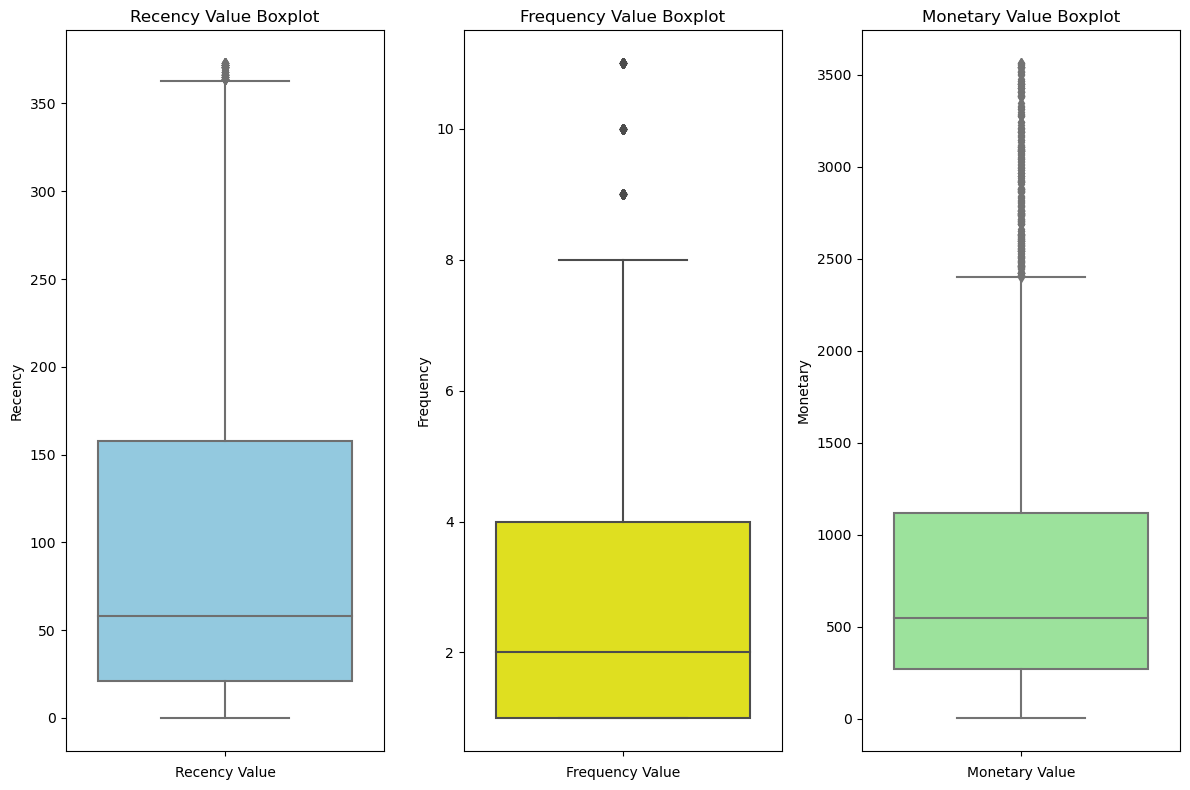

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
sns.boxplot(y=non_outliers_df['Recency'], color='skyblue')
plt.title('Recency Value Boxplot')
plt.xlabel('Recency Value')

plt.subplot(1, 3, 2)
sns.boxplot(y=non_outliers_df['Frequency'], color='yellow')
plt.title('Frequency Value Boxplot')
plt.xlabel('Frequency Value')

plt.subplot(1, 3, 3)
sns.boxplot(y=non_outliers_df['Monetary'], color='lightgreen')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.tight_layout()
plt.show()


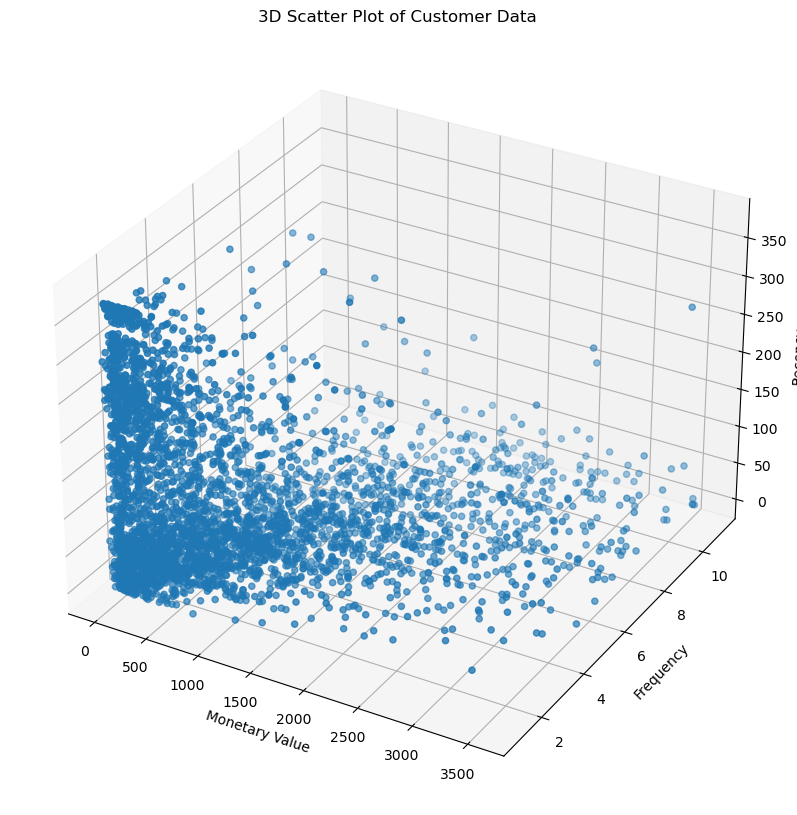

In [229]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["Monetary"], non_outliers_df["Frequency"], non_outliers_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

In [230]:
rfm_copy = non_outliers_df.drop(columns=["LastInvoiceDt"], errors="ignore")

**3. RFM SEGMENTATION**

In [233]:
rfm_copy[['Recency', 'Frequency', 'Monetary']].describe(percentiles=[0.25, 0.5, 0.75])


Recency  Frequency  Monetary
count  3793.00    3793.00   3793.00
mean     99.17       3.06    815.95
std     101.57       2.39    760.30
min       0.00       1.00      2.90
25%      21.00       1.00    266.97
50%      58.00       2.00    544.18
75%     158.00       4.00   1119.93
max     373.00      11.00   3563.85

NORMALIZATION

In [244]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select the RFM features
rfm_features = rfm_copy[['Recency', 'Frequency', 'Monetary']]

# Apply standard scaling (Z-score)
scaler = StandardScaler()
rfm_scaled_array = scaler.fit_transform(rfm_features)

# Convert back to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled_array, columns=['Recency', 'Frequency', 'Monetary'], index=rfm_copy.index)


In [245]:
rfm_scaled.describe()

Recency  Frequency  Monetary
count  3793.00    3793.00   3793.00
mean     -0.00       0.00     -0.00
std       1.00       1.00      1.00
min      -0.98      -0.86     -1.07
25%      -0.77      -0.86     -0.72
50%      -0.41      -0.45     -0.36
75%       0.58       0.39      0.40
max       2.70       3.33      3.61

In [242]:
# Custom bins for Recency (lower is better)
recency_bins = [0, 21, 58, 158, float('inf')]
recency_labels = [4, 3, 2, 1]

# Custom bins for Frequency (higher is better)
frequency_bins = [0, 1, 2, 4, float('inf')]
frequency_labels = [1, 2, 3, 4]

# Custom bins for Monetary (higher is better)
monetary_bins = [0, 267, 545, 1120, float('inf')]
monetary_labels = [1, 2, 3, 4]

# Apply binning
rfm_copy['R_Score'] = pd.cut(rfm_copy['Recency'], bins=recency_bins, labels=recency_labels, right=False)
rfm_copy['F_Score'] = pd.cut(rfm_copy['Frequency'], bins=frequency_bins, labels=frequency_labels, right=False)
rfm_copy['M_Score'] = pd.cut(rfm_copy['Monetary'], bins=monetary_bins, labels=monetary_labels, right=False)

# Calculate combined RFM score
rfm_copy['RFM_Score'] = (
    rfm_copy['R_Score'].astype(int) * 100 +
    rfm_copy['F_Score'].astype(int) * 10 +
    rfm_copy['M_Score'].astype(int)
)

rfm_copy.head()


CustomerID  Recency  Frequency  Monetary R_Score F_Score M_Score  RFM_Score
2    12348.00       74          4   1437.24       2       4       4        244
3    12349.00       18          1   1457.55       4       2       4        424
4    12350.00      309          1    294.40       1       2       2        122
5    12352.00       35          8   1265.41       3       4       4        344
6    12353.00      203          1     89.00       1       2       1        121

C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


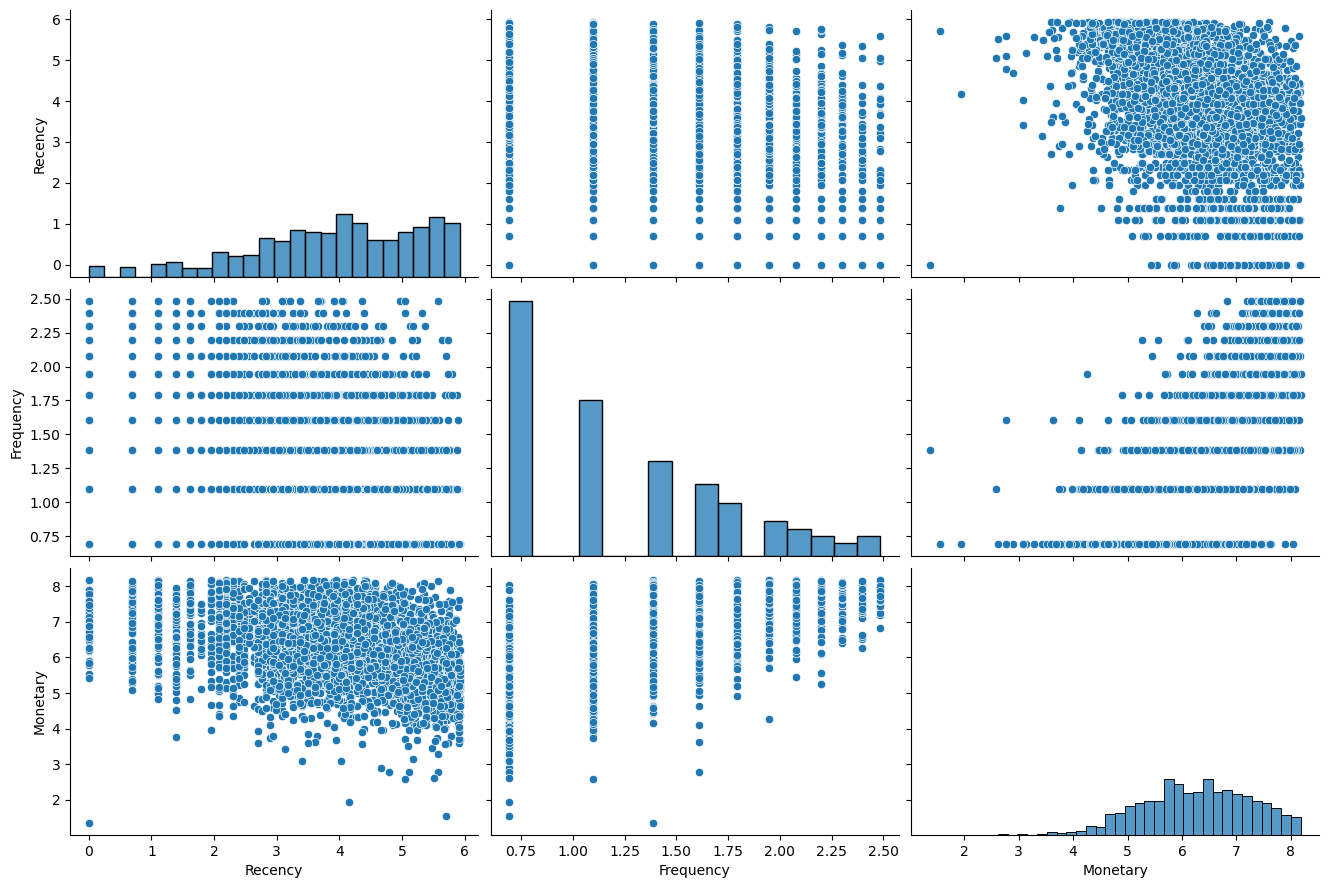

In [241]:
columns = ['Recency', 'Frequency', 'Monetary']
sns.pairplot(rfm_log[columns], height=3, aspect=1.5)

As most values in frequency are same (which is equal to 1 and 2), instead of quartiles, we divide the Frequency range into 4 equal-width bins and assign scores based on where each value falls.

C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


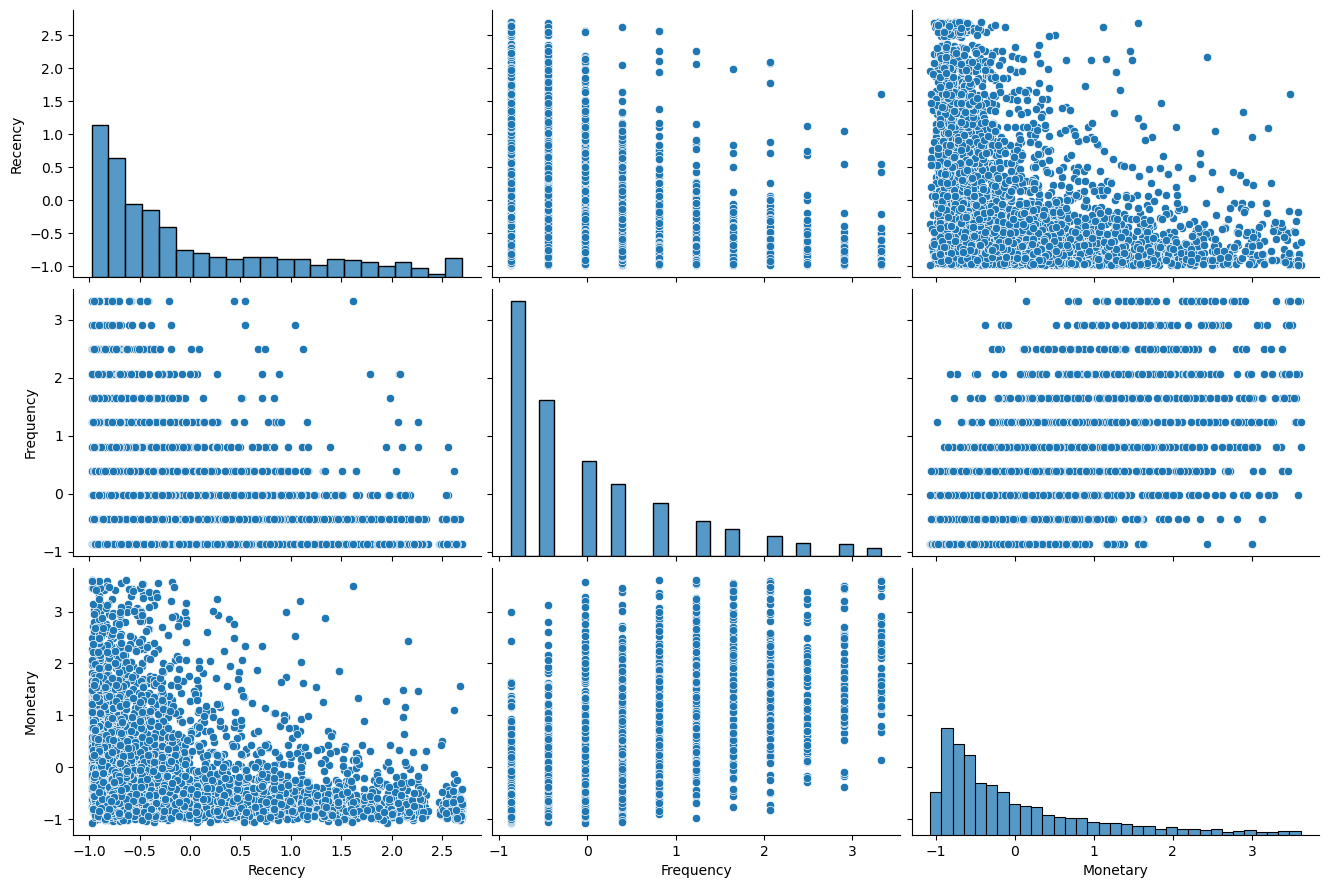

In [246]:
columns = ['Recency', 'Frequency', 'Monetary']
sns.pairplot(rfm_scaled[columns], height=3, aspect=1.5)

In [398]:
rfm_copy.dtypes

CustomerID      object
Frequency        int64
Monetary       float64
Recency          int64
R_Score       category
F_Score       category
M_Score       category
RFM_Score        int64
dtype: object

In [247]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# columns = ['Recency', 'Frequency', 'Monetary']
# scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(rfm_copy[columns]) 

# Apply PCA
pca = PCA()
pca.fit(rfm_scaled)

# Check explained variance ratio for each component
print(pca.explained_variance_ratio_)

# Use explained variance ratio as weights
weights = pca.components_[0]  # First principal component
weights = weights / weights.sum()  # Normalize to sum to 1
print("RFM Weights from PCA:", weights)


[0.66148888 0.2416303  0.09688081]
RFM Weights from PCA: [-0.60131217  0.80937465  0.79193752]


Negative value in recency indicates-> opposite effect of recency value (as PCA is applied on RFM rather than their scores)

**CUSTOMER SEGMENTATION**

In [248]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

rfm_sc = pd.DataFrame(rfm_scaled, columns=columns, index=rfm_copy.index)
# Select RFM features for clustering
rfm_ft = rfm_sc[['Recency', 'Frequency', 'Monetary']]


In [249]:
from scipy.stats import skew
skewness = rfm_ft.apply(lambda x: skew(x))
print(skewness)

Recency     1.12
Frequency   1.34
Monetary    1.48
dtype: float64


Data is not that skewed 

C:\Users\mansi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mansi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mansi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mansi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

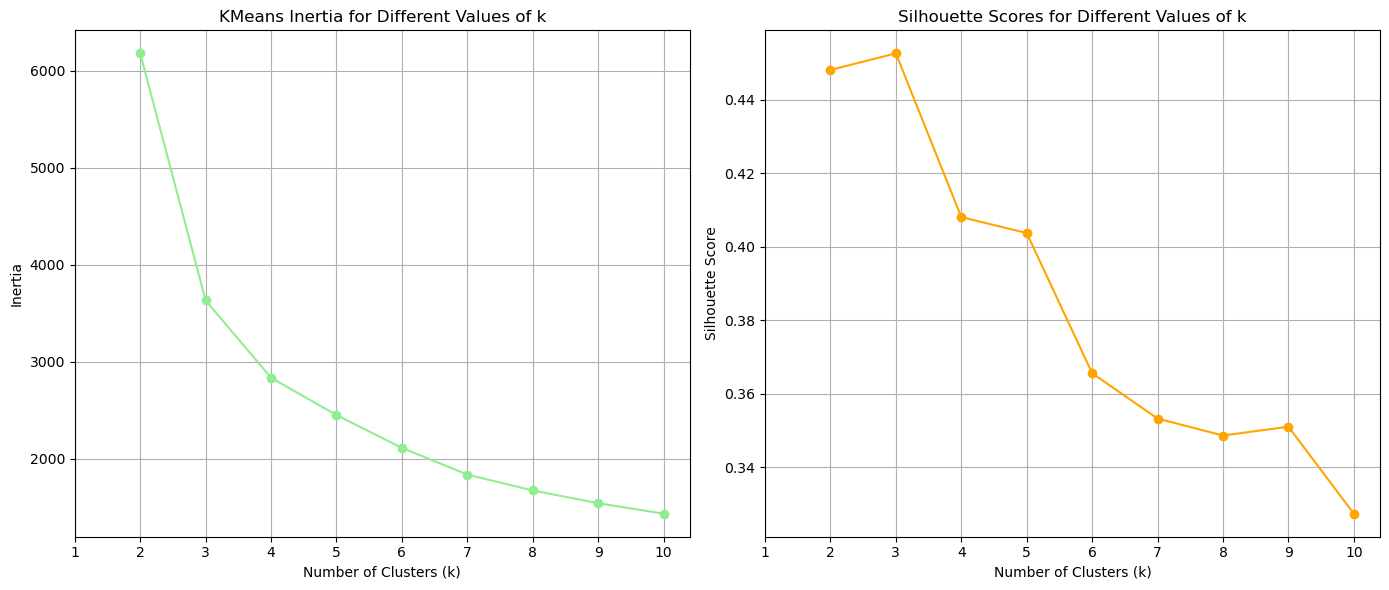

In [250]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []  # Within-Cluster-Sum-of-Squares
sil_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, max_iter=1000)
    kmeans.fit(rfm_sc)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(rfm_sc, kmeans.labels_))
    
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(2,11), wcss, marker='o', color="lightgreen")
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1,11))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2,11), sil_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(1,11))
plt.grid(True)

plt.tight_layout()
plt.show()

In [251]:
kmeans = KMeans(n_clusters=3, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(rfm_sc)
cluster_labels

C:\Users\mansi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 2, 1, ..., 1, 2, 0])

In [252]:
non_outliers_df["Cluster"] = cluster_labels
non_outliers_df

C:\Users\mansi\AppData\Local\Temp\ipykernel_25016\1071184375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["Cluster"] = cluster_labels


CustomerID  Recency  Frequency  Monetary       LastInvoiceDt  Cluster
2       12348.00       74          4   1437.24 2011-09-25 13:13:00        0
3       12349.00       18          1   1457.55 2011-11-21 09:51:00        2
4       12350.00      309          1    294.40 2011-02-02 16:01:00        1
5       12352.00       35          8   1265.41 2011-11-03 14:37:00        0
6       12353.00      203          1     89.00 2011-05-19 17:47:00        1
...          ...      ...        ...       ...                 ...      ...
4356    18278.00       73          1    173.90 2011-09-27 11:58:00        2
4357    18280.00      277          1    180.60 2011-03-07 09:52:00        1
4358    18281.00      180          1     80.82 2011-06-12 10:53:00        1
4359    18282.00        7          3    176.60 2011-12-02 11:43:00        2
4361    18287.00       42          3   1837.28 2011-10-28 09:29:00        0

[3793 rows x 6 columns]

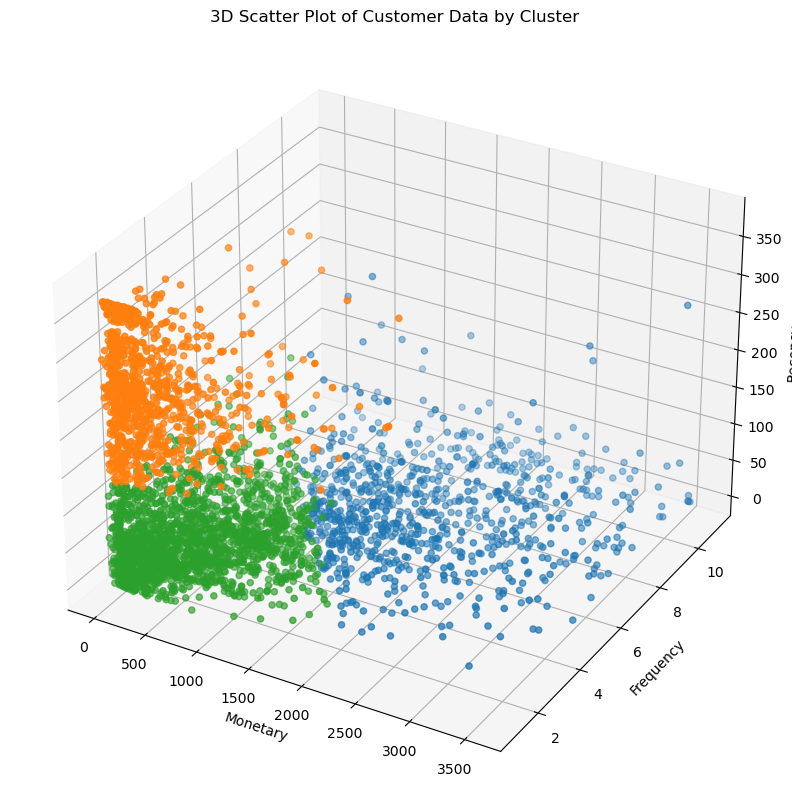

In [253]:
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c'   # Green
                 }
                 # 3: '#d62728'}  # Red

colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['Monetary'], 
                     non_outliers_df['Frequency'], 
                     non_outliers_df['Recency'], 
                     c=colors,  # Use mapped solid colors
                     marker='o')

ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

In [254]:
# Silhouette Score (measures how similar a sample is to its own cluster)
silhouette_avg = silhouette_score(rfm_sc, non_outliers_df['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Inertia (sum of squared distances of samples to their closest cluster center)
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")


Silhouette Score: 0.4525890101230451
Inertia: 3632.3138757798074


C:\Users\mansi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the average silhouette_score is: 0.4481


C:\Users\mansi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the average silhouette_score is: 0.4526


C:\Users\mansi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette_score is: 0.4081


C:\Users\mansi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the average silhouette_score is: 0.4037


C:\Users\mansi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, the average silhouette_score is: 0.3656


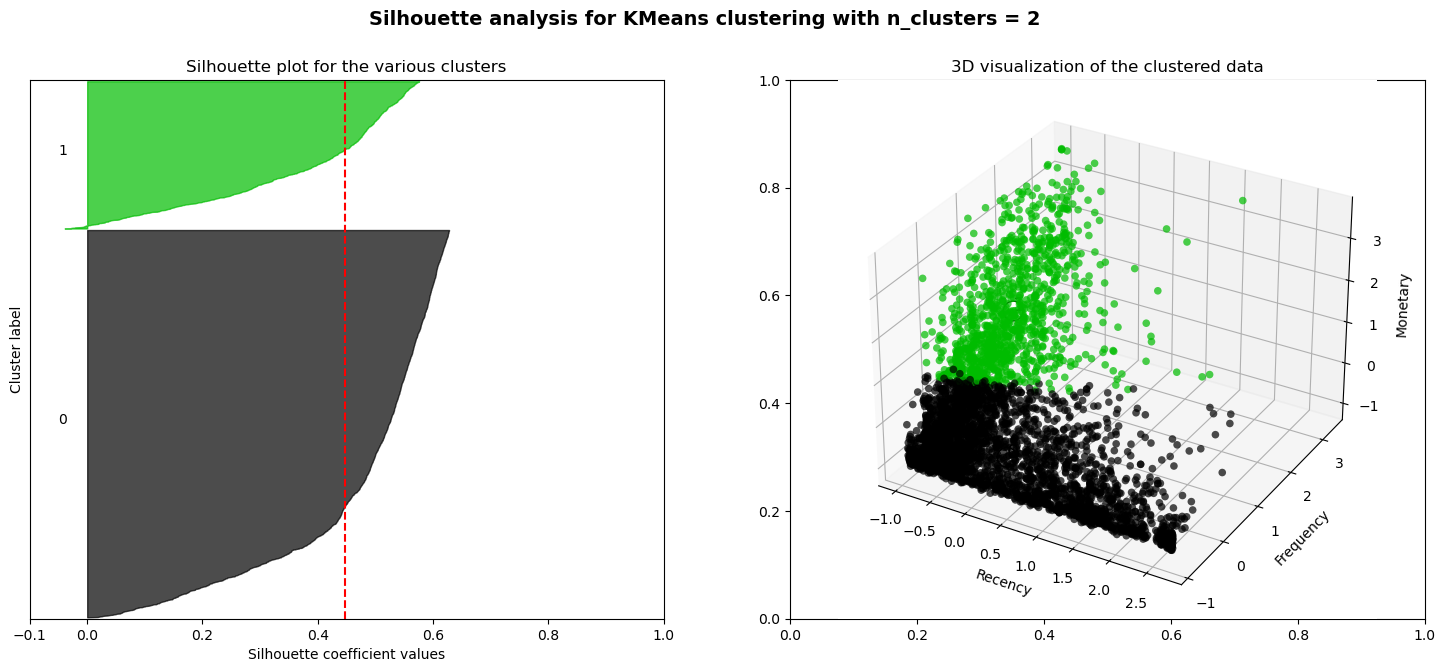

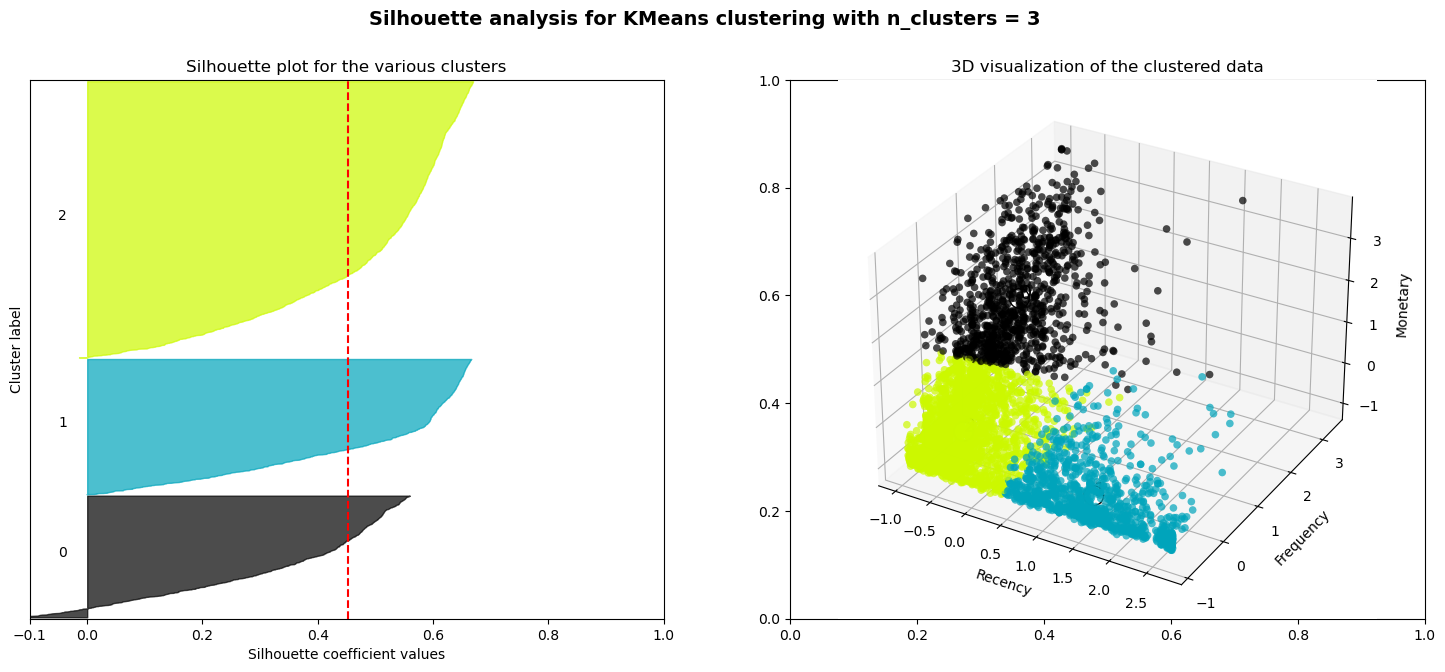

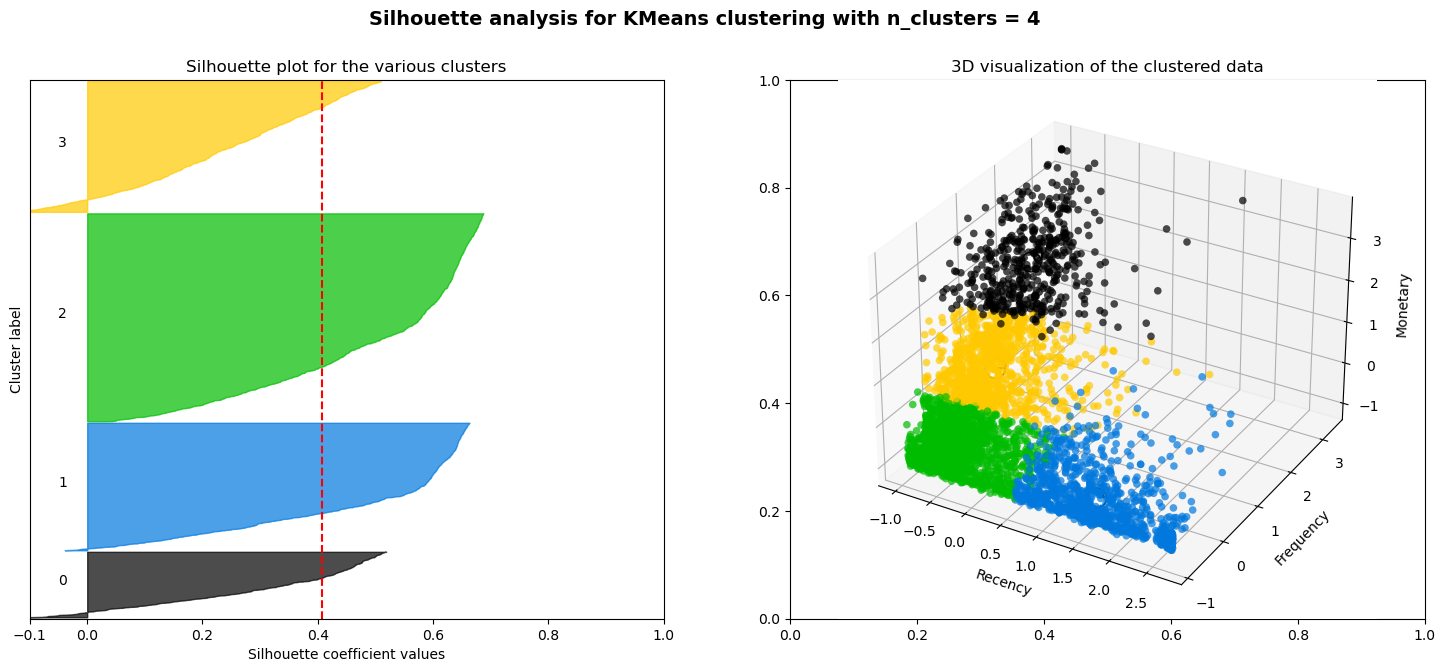

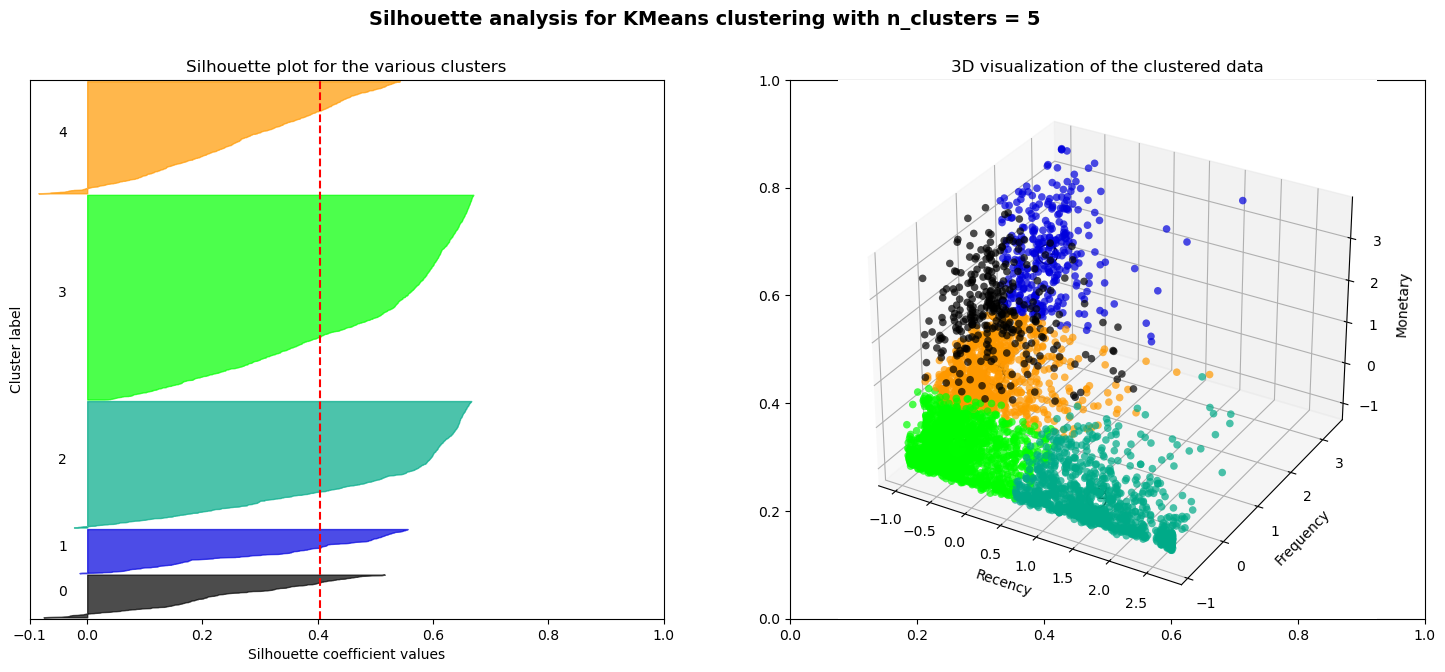

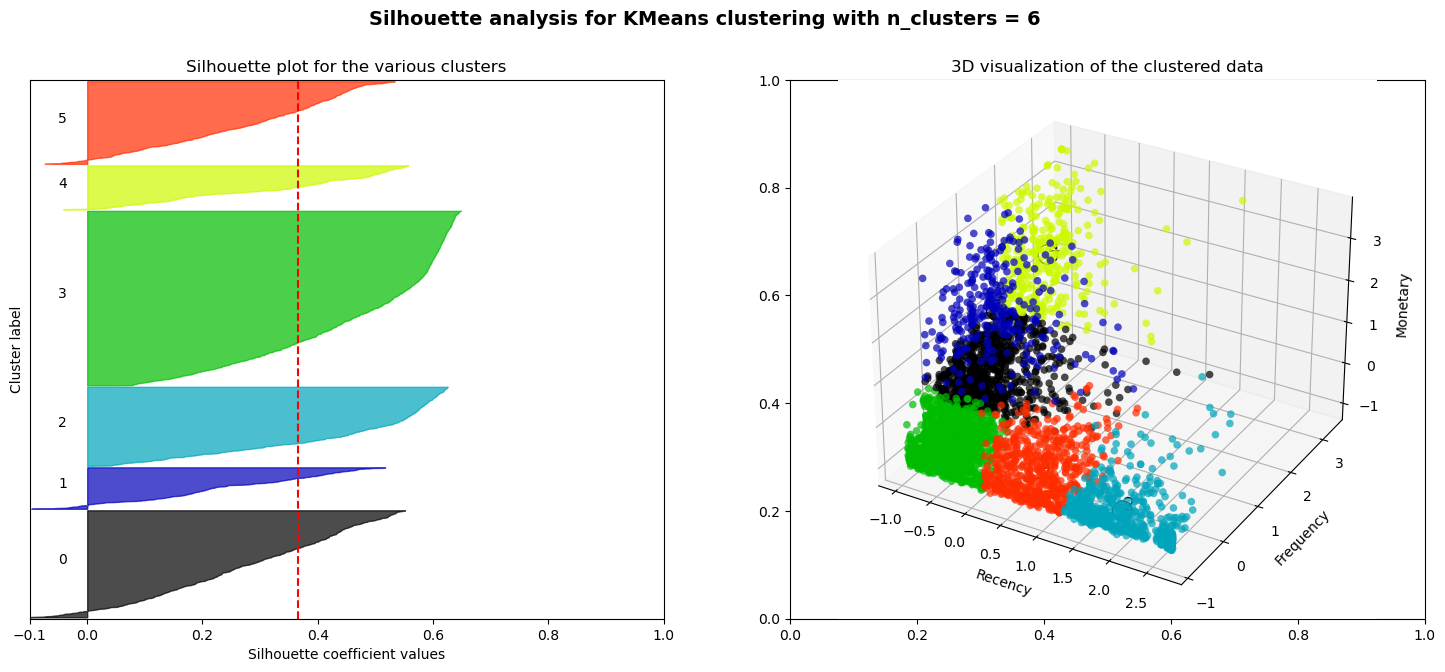

In [255]:
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm


# Define the range of clusters to evaluate
range_n_clusters = range(2, 7)

for n_clust in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Set limits for the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(rfm_sc) + (n_clust + 1) * 10])

    # Initialize KMeans and fit the data
    clusterer = KMeans(n_clusters=n_clust, random_state=42)
    cluster_labels = clusterer.fit_predict(rfm_sc)

    # Compute the average silhouette score
    sil_avg = silhouette_score(rfm_sc, cluster_labels)
    print(f"For n_clusters = {n_clust}, the average silhouette_score is: {sil_avg:.4f}")

    # Compute the silhouette scores for each sample
    sample_silval = silhouette_samples(rfm_sc, cluster_labels)

    y_lower = 10
    for i in range(n_clust):
        # Aggregate the silhouette scores for samples in cluster i
        ith_clust_silval = sample_silval[cluster_labels == i]
        ith_clust_silval.sort()

        size_clusteri = ith_clust_silval.shape[0]
        y_upper = y_lower + size_clusteri

        # Fill the silhouette plot
        color = cm.nipy_spectral(float(i) / n_clust)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_clust_silval, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plot with the cluster number
        ax1.text(-0.05, y_lower + 0.5 * size_clusteri, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Set title and labels for the silhouette plot
    ax1.set_title("Silhouette plot for the various clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Add a vertical line for the average silhouette score
    ax1.axvline(x=sil_avg, color="red", linestyle="--")

    # Clear the y-axis labels/ticks
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot: 3D scatter plot of the clustered data
    ax2 = fig.add_subplot(122, projection='3d')

    # Assign colors to each cluster
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clust)
    ax2.scatter(rfm_sc['Recency'], rfm_sc['Frequency'], rfm_sc['Monetary'], c=colors, s=30, lw=0, alpha=0.7)

    # Plot the cluster centers in 3D
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    # Label the cluster centers
    for i, c in enumerate(centers):
        ax2.text(c[0], c[1], c[2], str(i), color='black', fontsize=14)

    # Set title and labels for the 3D plot
    ax2.set_title("3D visualization of the clustered data")
    ax2.set_xlabel("Recency")
    ax2.set_ylabel("Frequency")
    ax2.set_zlabel("Monetary")

    # Add a main title for the entire figure
    plt.suptitle(f"Silhouette analysis for KMeans clustering with n_clusters = {n_clust}", fontsize=14, fontweight='bold')

# Show all the plots after the loop finishes
plt.show()

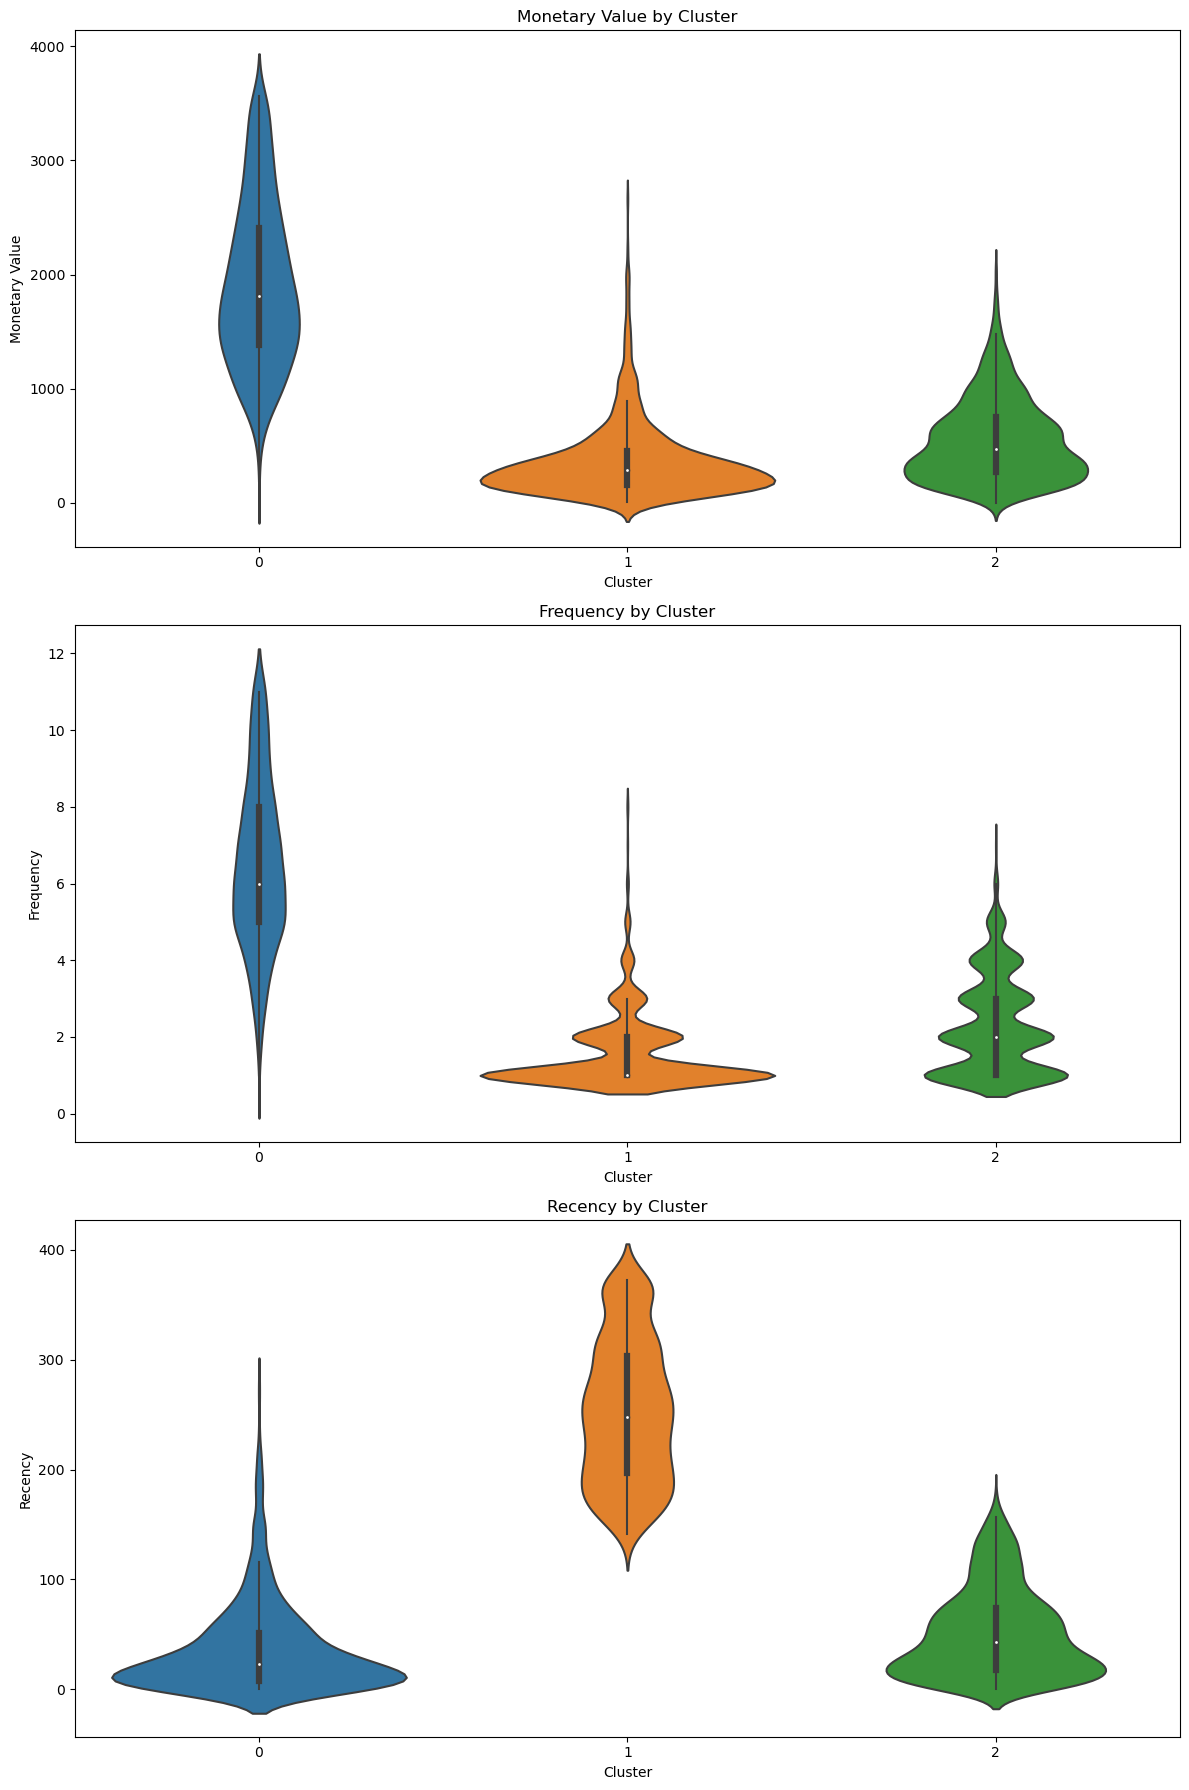

In [256]:
plt.figure(figsize=(12, 18))

# Plot 1: Monetary
plt.subplot(3, 1, 1)
sns.violinplot(x='Cluster', y='Monetary', data=non_outliers_df, palette=cluster_colors)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

# Plot 2: Frequency
plt.subplot(3, 1, 2)
sns.violinplot(x='Cluster', y='Frequency', data=non_outliers_df, palette=cluster_colors)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

# Plot 3: Recency
plt.subplot(3, 1, 3)
sns.violinplot(x='Cluster', y='Recency', data=non_outliers_df, palette=cluster_colors)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()


Cluster 0 (Blue) – "High Valued Customers "
Your most loyal and high-spending customers who shop frequently. Keep them happy and appreciated.
Action: Offer exclusive perks, early access to deals, and recognition to maintain their engagement.


Cluster 1 (Orange) –  "Re-engage"
These customers buy infrequently and haven't shopped in a while. They need a push to return.
Action: Send special offers, reminders, or discounts to re-engage them.

Cluster 2 (Green) – "Potential Growers"
These are newer or occasional buyers who have made recent purchases. They need encouragement to buy more.
Action: Provide great service, personalized recommendations, and small incentives to build stronger habits. 

<!-- Cluster 3 (Red) – "Loyal Customers"
These are valuable customers who buy regularly, though not always recently. Keep them engaged to maintain their loyalty.
Action: Offer loyalty rewards, personalized deals, and regular communication to keep them coming back. -->


In [257]:
overlap_indices = vip_customers.index.intersection(frequency_outliers_df.index)

money_out = vip_customers.drop(overlap_indices) #customerids not in the common FM coustomerids
freq_out = frequency_outliers_df.drop(overlap_indices) # custoemrs not in the common FM 
mon_freq = vip_customers.loc[overlap_indices] #common customers for both these outliers

money_out["Cluster"] = -1
freq_out["Cluster"] = -2
mon_freq["Cluster"] = -3
outlier_clusters_df = pd.concat([money_out, freq_out, mon_freq])
outlier_clusters_df.head()

CustomerID  Recency  Frequency  Monetary       LastInvoiceDt  Cluster
1     12347.00        1          7   4310.00 2011-12-07 15:52:00       -1
10    12357.00       32          1   6207.67 2011-11-06 16:07:00       -1
12    12359.00        7          6   6245.53 2011-12-02 11:21:00       -1
27    12378.00      129          1   4008.62 2011-08-02 10:34:00       -1
50    12409.00       78          7  11056.93 2011-09-22 10:38:00       -1

In [260]:
outlier_clusters_df[outlier_clusters_df['Monetary']==outlier_clusters_df['Monetary'].max()]

CustomerID  Recency  Frequency  Monetary       LastInvoiceDt  Cluster
1699    14646.00        1         73 278778.02 2011-12-08 12:12:00       -3

In [258]:
non_outliers_df.head()

CustomerID  Recency  Frequency  Monetary       LastInvoiceDt  Cluster
2    12348.00       74          4   1437.24 2011-09-25 13:13:00        0
3    12349.00       18          1   1457.55 2011-11-21 09:51:00        2
4    12350.00      309          1    294.40 2011-02-02 16:01:00        1
5    12352.00       35          8   1265.41 2011-11-03 14:37:00        0
6    12353.00      203          1     89.00 2011-05-19 17:47:00        1

In [259]:
outlier_clusters_df[outlier_clusters_df['Cluster']==-3].sort_values(by="Monetary").head()

CustomerID  Recency  Frequency  Monetary       LastInvoiceDt  Cluster
1323    14132.00        1         12   3580.13 2011-12-07 13:35:00       -3
3114    16570.00        8         15   3622.95 2011-12-01 08:56:00       -3
696     13266.00       10         19   3717.67 2011-11-28 14:39:00       -3
554     13069.00        0         27   3717.82 2011-12-09 08:39:00       -3
1430    14282.00        2         15   3729.34 2011-12-06 17:04:00       -3

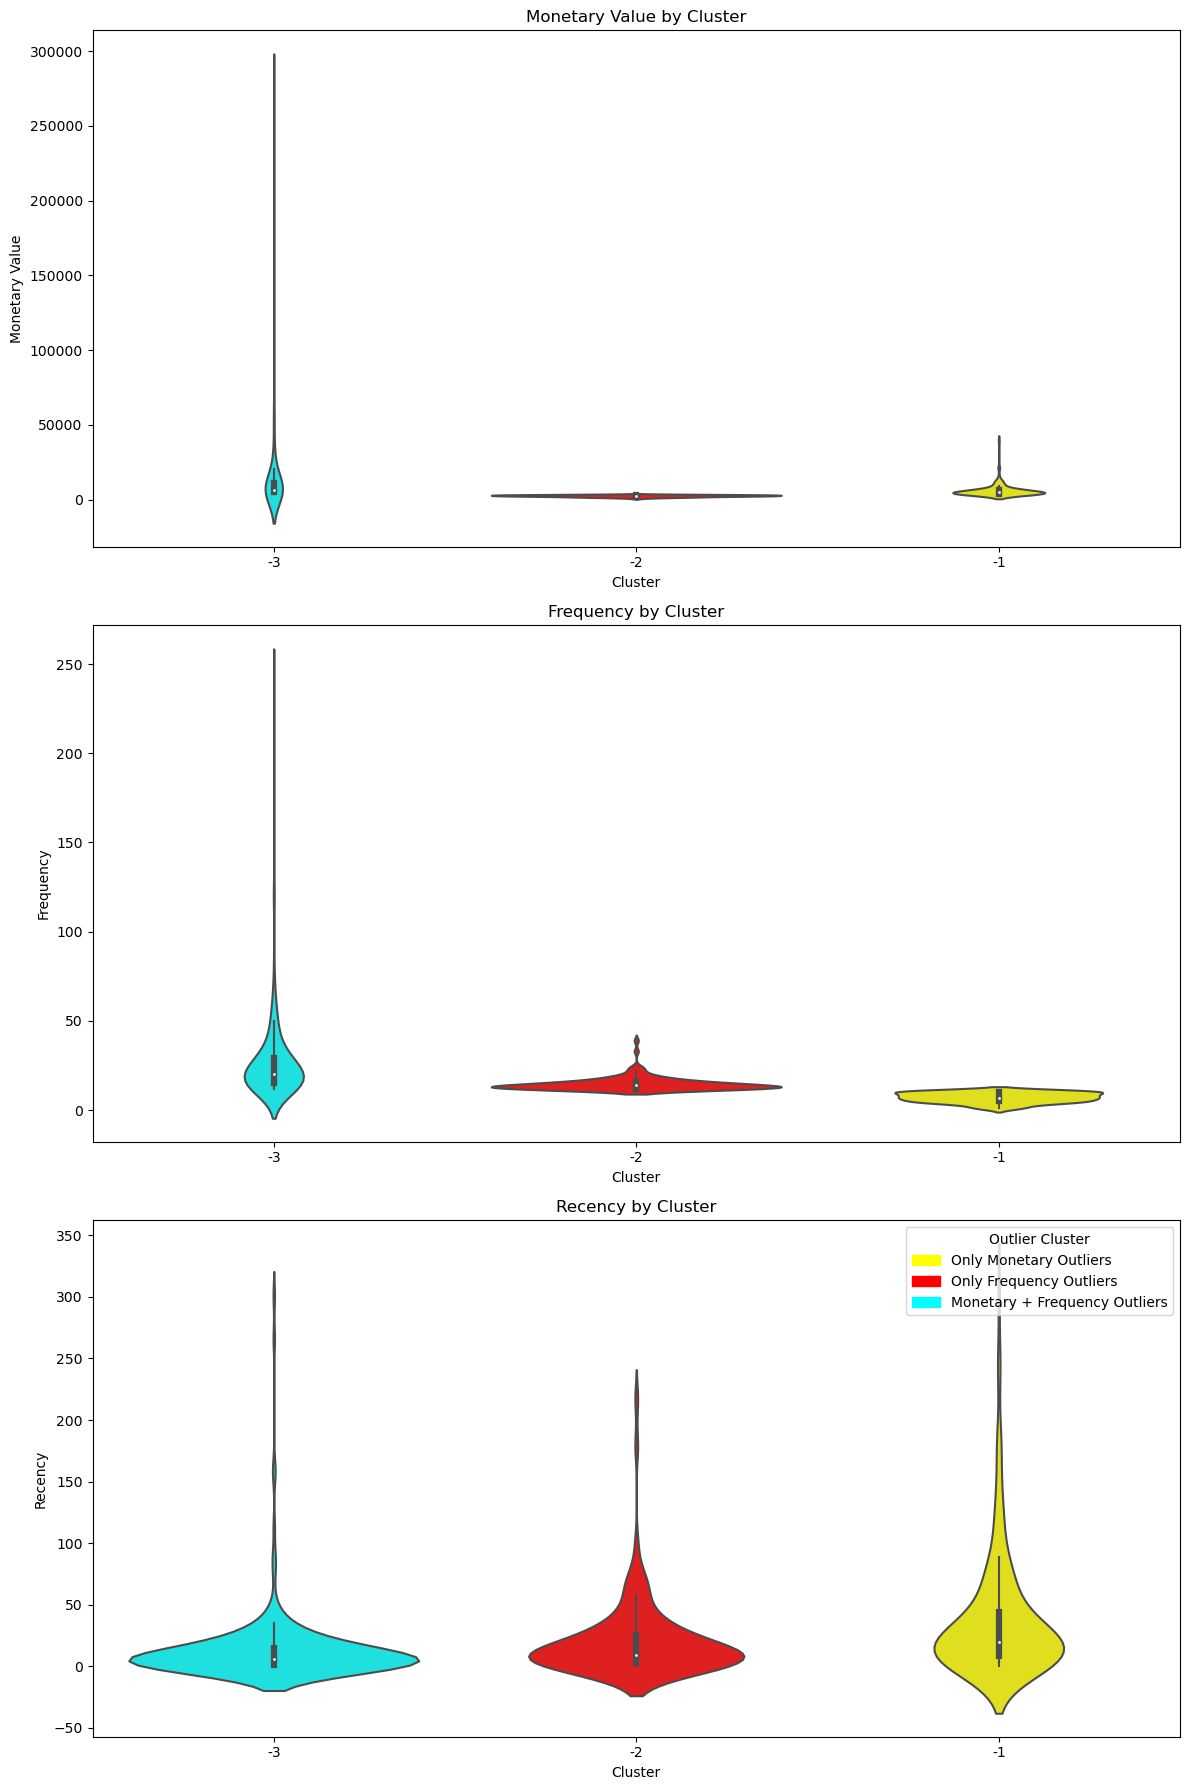

In [262]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define consistent color palette
cluster_colors = {-1: 'yellow', -2: 'red', -3: 'cyan'}

plt.figure(figsize=(12, 18))

# Monetary Plot
plt.subplot(3, 1, 1)
sns.violinplot(x='Cluster', y='Monetary', data=outlier_clusters_df, palette=cluster_colors)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

# Frequency Plot
plt.subplot(3, 1, 2)
sns.violinplot(x='Cluster', y='Frequency', data=outlier_clusters_df, palette=cluster_colors)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

# Recency Plot
plt.subplot(3, 1, 3)
sns.violinplot(x='Cluster', y='Recency', data=outlier_clusters_df, palette=cluster_colors)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

import matplotlib.patches as mpatches

# Define the labels and colors
legend_labels = {
    -1: 'Only Monetary Outliers',
    -2: 'Only Frequency Outliers',
    -3: 'Monetary + Frequency Outliers'
}

# Create custom legend handles
handles = [mpatches.Patch(color=color, label=legend_labels[cluster]) 
           for cluster, color in cluster_colors.items()]

# Add legend to the last plot (you can adjust placement as needed)
plt.legend(handles=handles, title='Outlier Cluster', loc='upper right')


plt.tight_layout()
plt.show()


**RFM SCORE**

In [263]:
rfm_cluster = pd.concat([non_outliers_df, outlier_clusters_df], ignore_index=True)

In [264]:
rfm_cluster = rfm_cluster.drop(columns=["LastInvoiceDt"], errors="ignore")

In [265]:
rfm_cluster.head()

CustomerID  Recency  Frequency  Monetary  Cluster
0    12348.00       74          4   1437.24        0
1    12349.00       18          1   1457.55        2
2    12350.00      309          1    294.40        1
3    12352.00       35          8   1265.41        0
4    12353.00      203          1     89.00        1

In [268]:
rfm_cluster[rfm_cluster['Cluster']==-2]

CustomerID  Recency  Frequency  Monetary  Cluster
3933    12395.00       15         15   2662.28       -2
3934    12417.00        2         12   3155.80       -2
3935    12494.00        9         13    995.35       -2
3936    12523.00        1         13   1655.57       -2
3937    12553.00        7         14   3238.25       -2
...          ...      ...        ...       ...      ...
4044    18065.00        5         15   2380.08       -2
4045    18075.00       22         14   2538.72       -2
4046    18144.00        7         12   2888.75       -2
4047    18241.00        9         18   2058.09       -2
4048    18283.00        3         16   2088.93       -2

[116 rows x 5 columns]

**5. Segment Profiling**

In [269]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)

    # Sort by cluster
    df_new = df_new.sort_values(by='Cluster', ascending=True)

    return df_new

rfm_values(non_outliers_df)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         37.00      6.00  1922.00   866
1        253.00      2.00   367.00   962
2         51.00      2.00   548.00  1965

Cluster 0 - Loyal Customers <br>
Customers in this cluster can be interpreted as very Loyal Customers as they frequently buy and their rceency is also one if the least. They tend to spend a lot.

Cluster 1 - Passerby Customer <br>
Customers in this cluster can be interpreted as passerby customers as their last purchase is long ago (R=4), purchased very few (F=4) and spent little (M=4). The company would have to come up with new strategies to make them permanent members.

Cluster 2 - Best Customers <br>
Customers in this cluster can be interpreted as “Best Customers” segment as they purchase recently (R=1), frequent buyers (F=1), and spent the most (M=1).

Cluster 3 - Almost Lost Customers <br>
Customers in this cluster can be interpreted as “Almost Lost” customers as they Haven’t purchased for some time(R=3) but used to purchase frequently and spent a lot.



In [270]:
# Analyze and profile each customer segment


for cluster_label in range(0, 3):
    cluster_data = non_outliers_df[non_outliers_df['Cluster'] == cluster_label]

    print(f"\n\n------ Profile for Cluster {cluster_label} ------")

    # General statistics
    print("Cluster Size:", len(cluster_data))

    # RFM scores
    print("Recency:")
    print("Mean:", cluster_data['Recency'].mean())
    print("Min:", cluster_data['Recency'].min())
    print("Max:", cluster_data['Recency'].max())

    print("\nFrequency:")
    print("Mean:", cluster_data['Frequency'].mean())
    print("Min:", cluster_data['Frequency'].min())
    print("Max:", cluster_data['Frequency'].max())

    print("\nMonetary Value:")
    print("Mean:", cluster_data['Monetary'].mean())
    print("Min:", cluster_data['Monetary'].min())
    print("Max:", cluster_data['Monetary'].max())



------ Profile for Cluster 0 ------
Cluster Size: 866
Recency:
Mean: 37.2933025404157
Min: 0
Max: 280

Frequency:
Mean: 6.498845265588915
Min: 1
Max: 11

Monetary Value:
Mean: 1921.905311778291
Min: 191.17000000000002
Max: 3563.85


------ Profile for Cluster 1 ------
Cluster Size: 962
Recency:
Mean: 252.55613305613306
Min: 141
Max: 373

Frequency:
Mean: 1.5758835758835759
Min: 1
Max: 8

Monetary Value:
Mean: 367.47247401247404
Min: 3.75
Max: 2661.24


------ Profile for Cluster 2 ------
Cluster Size: 1965
Recency:
Mean: 51.35623409669211
Min: 0
Max: 178

Frequency:
Mean: 2.275826972010178
Min: 1
Max: 7

Monetary Value:
Mean: 548.0932569974555
Min: 2.8999999999941792
Max: 2062.06


In [271]:
rfm_cluster[["Cluster", "Recency", "Frequency", "Monetary"]].groupby("Cluster").agg(["mean", "sum", "count"])

Recency               Frequency             Monetary                 
           mean     sum count      mean   sum count     mean        sum count
Cluster                                                                      
-3        13.23    3586   271     27.27  7390   271 14951.64 4051894.09   271
-2        20.47    2375   116     14.78  1715   116  2524.88  292886.33   116
-1        38.29    5360   140      7.14  1000   140  6079.73  851161.52   140
 0        37.29   32296   866      6.50  5628   866  1921.91 1664370.00   866
 1       252.56  242959   962      1.58  1516   962   367.47  353508.52   962
 2        51.36  100915  1965      2.28  4472  1965   548.09 1077003.25  1965


--- Customer Segment 2 ---
Number of Customers: 879

RFM Statistics:
          Recency   Frequency     Monetary
count  879.000000  879.000000   879.000000
mean    34.992036    6.825939  2019.184300
std     39.787461    1.982948   923.881854
min      0.000000    1.000000   191.170000
25%      8.000000    5.000000  1304.350000
50%     21.000000    6.000000  1842.730000
75%     49.500000    8.000000  2598.275000
max    280.000000   11.000000  4595.810000


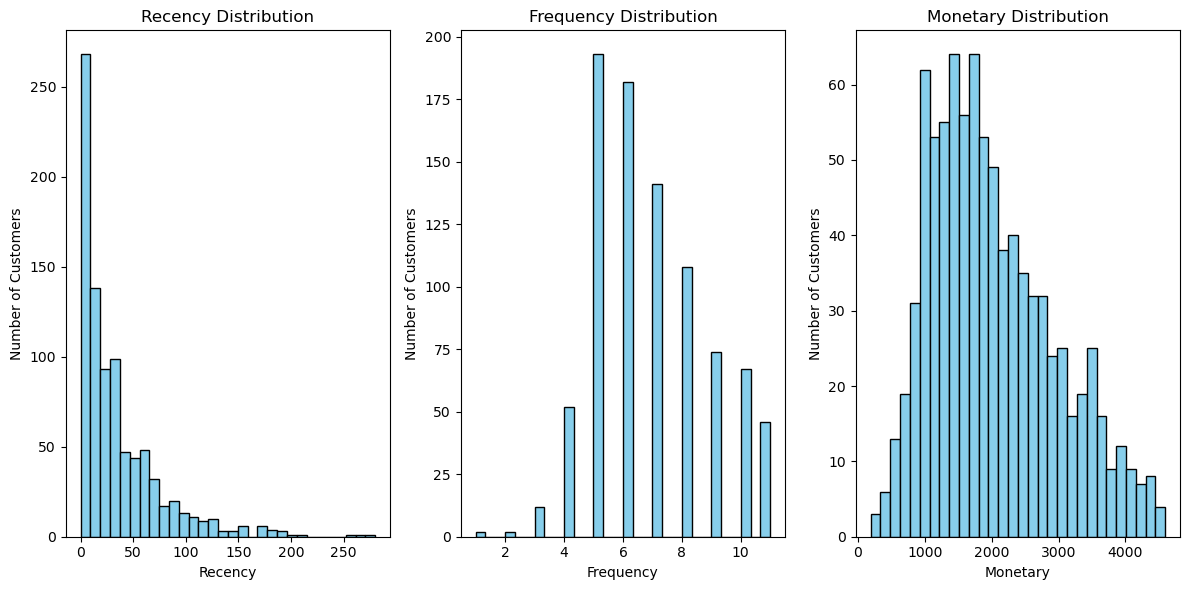


--- Customer Segment 0 ---
Number of Customers: 2015

RFM Statistics:
           Recency    Frequency      Monetary
count  2015.000000  2015.000000  2.015000e+03
mean     51.314640     2.247643  5.930388e+02
std      39.929733     1.178554  4.537001e+02
min       0.000000     1.000000  1.776357e-15
25%      18.000000     1.000000  2.669100e+02
50%      43.000000     2.000000  4.851900e+02
75%      74.000000     3.000000  7.793450e+02
max     168.000000     6.000000  4.008620e+03


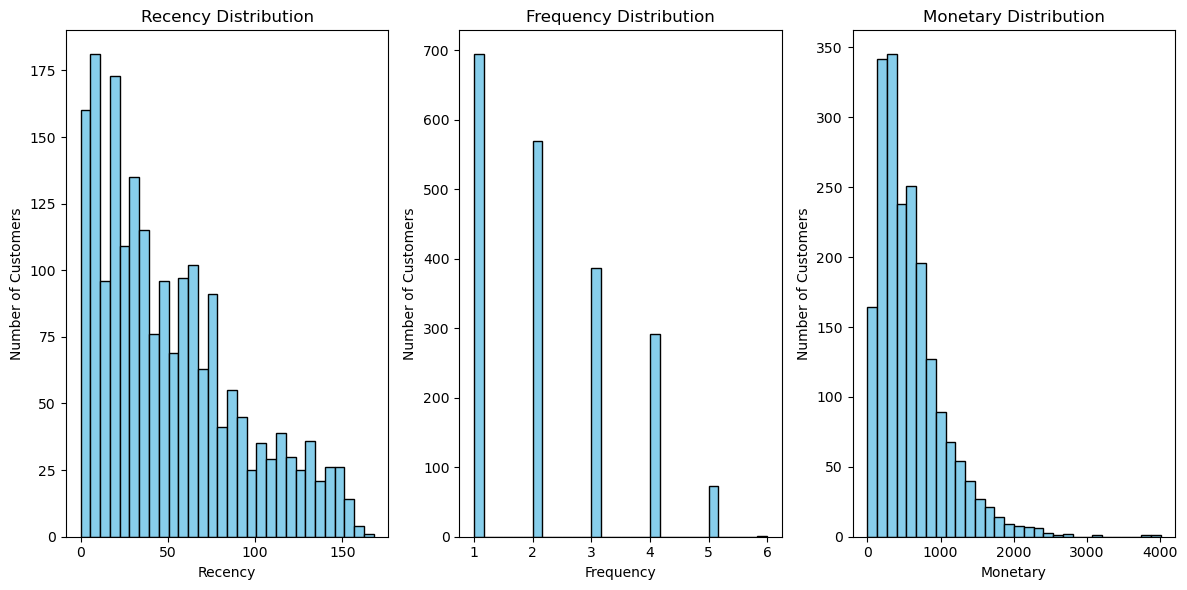


--- Customer Segment 3 ---
Number of Customers: 972

RFM Statistics:
          Recency   Frequency      Monetary
count  972.000000  972.000000  9.720000e+02
mean   252.252058    1.602881  3.914177e+02
std     64.050180    0.982185  3.968864e+02
min    145.000000    1.000000  3.552714e-15
25%    197.000000    1.000000  1.579150e+02
50%    247.000000    1.000000  2.903800e+02
75%    302.250000    2.000000  4.590400e+02
max    373.000000    8.000000  3.641070e+03


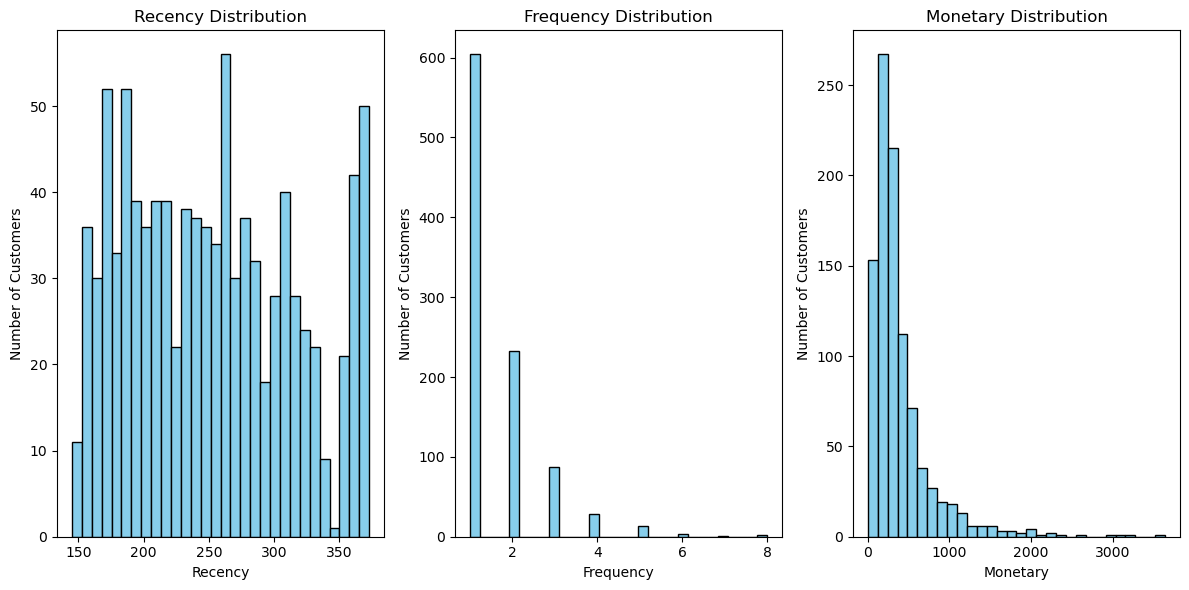


--- Customer Segment 1 ---
Number of Customers: 69

RFM Statistics:
          Recency  Frequency      Monetary
count   69.000000  69.000000     69.000000
mean    30.376812   7.536232   7200.213188
std     32.804726   2.893094   2558.390665
min      0.000000   1.000000   4762.320000
25%      9.000000   6.000000   5461.620000
50%     21.000000   8.000000   6207.670000
75%     38.000000  10.000000   8117.420000
max    189.000000  11.000000  16291.260000


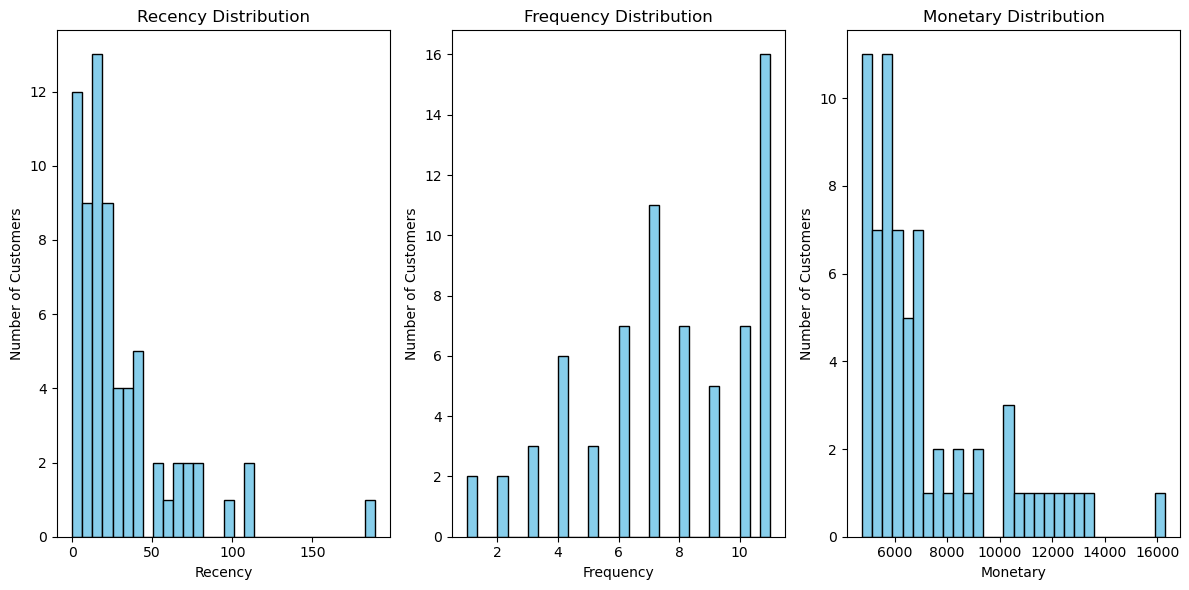


--- Customer Segment -1 ---
Number of Customers: 3

RFM Statistics:
          Recency  Frequency      Monetary
count    3.000000   3.000000      3.000000
mean   139.333333   6.333333  27393.136667
std    121.005510   4.041452  10591.434186
min      3.000000   4.000000  21024.010000
25%     92.000000   4.000000  21279.955000
50%    181.000000   4.000000  21535.900000
75%    207.500000   7.500000  30577.700000
max    234.000000  11.000000  39619.500000


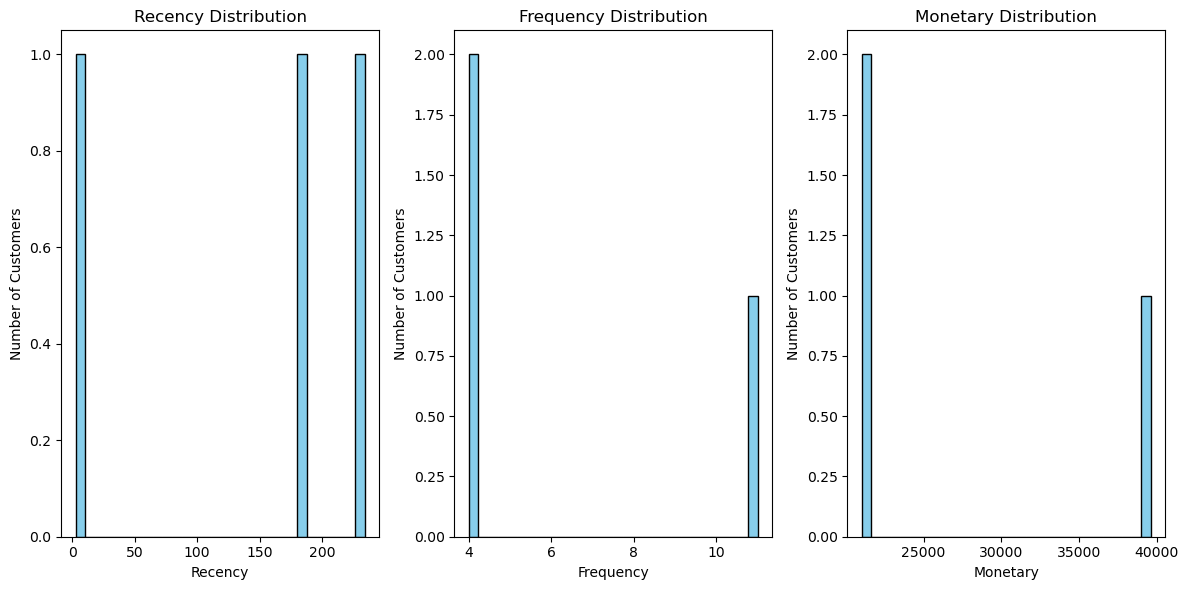


--- Customer Segment -2 ---
Number of Customers: 349

RFM Statistics:
          Recency   Frequency      Monetary
count  349.000000  349.000000    349.000000
mean    16.458453   19.793696   5633.572292
std     31.864866   10.655411   3596.843372
min      0.000000   12.000000    587.450000
25%      2.000000   14.000000   3025.240000
50%      8.000000   16.000000   4665.580000
75%     19.000000   22.000000   7024.530000
max    301.000000  125.000000  18660.410000


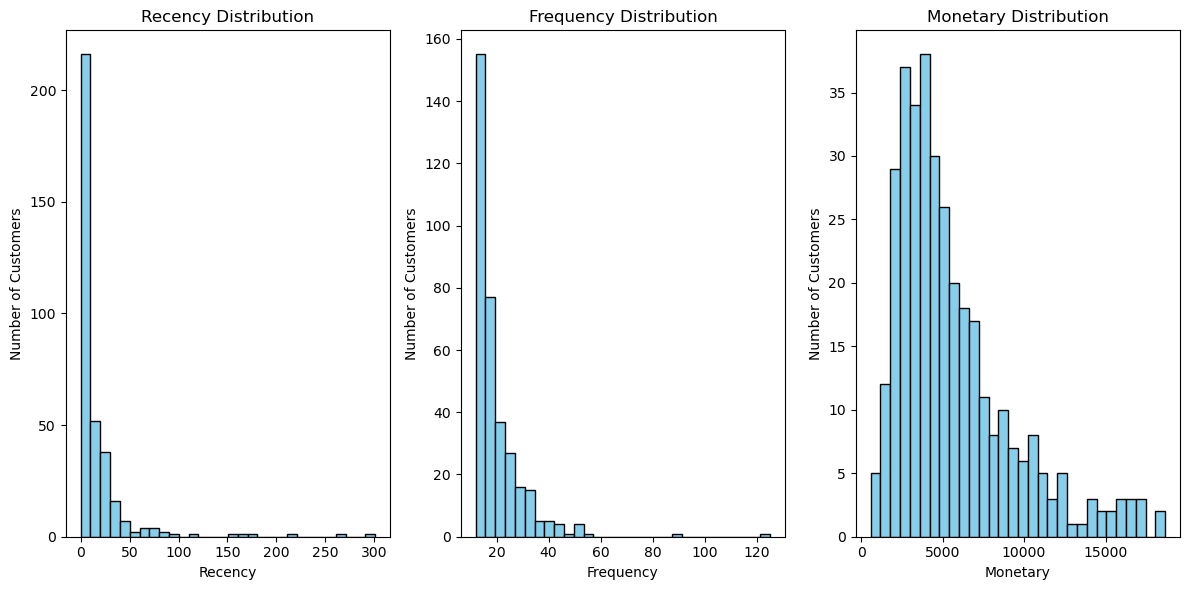


--- Customer Segment -3 ---
Number of Customers: 38

RFM Statistics:
         Recency   Frequency       Monetary
count  38.000000   38.000000      38.000000
mean    5.710526   57.815789   62479.798421
std     8.417831   51.926068   60952.252275
min     0.000000   14.000000   19638.590000
25%     0.000000   24.000000   28143.780000
50%     2.500000   45.000000   38107.180000
75%     7.750000   62.250000   60098.495000
max    38.000000  242.000000  278778.020000


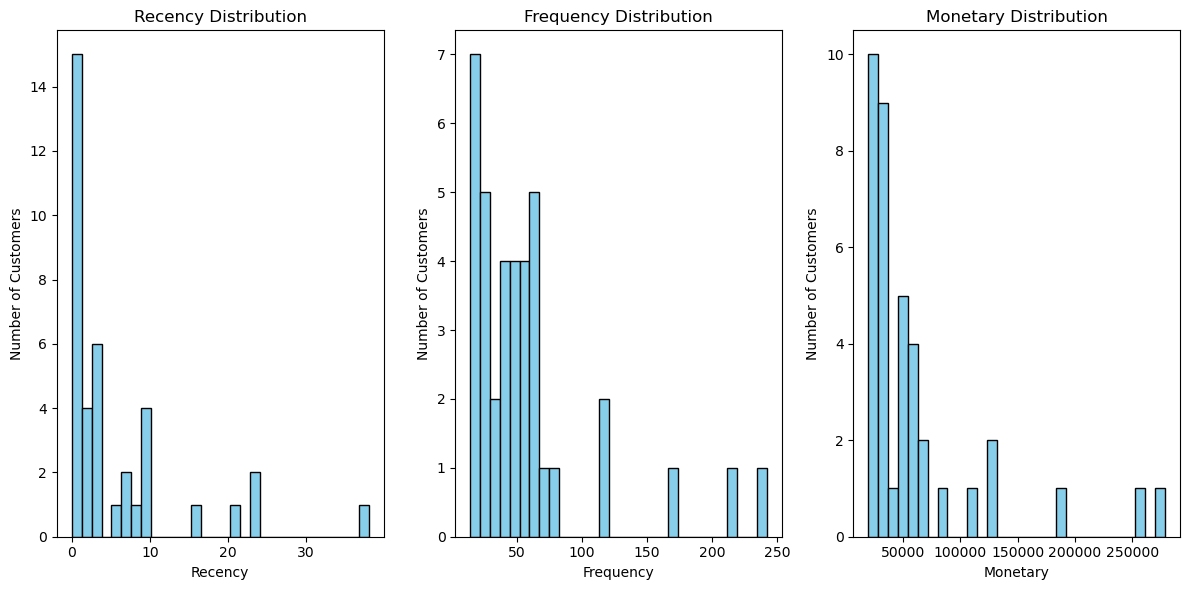

In [123]:
# Profile each customer segment
for cluster in rfm_cluster['Cluster'].unique():
    segment_data = rfm_cluster[rfm_cluster['Cluster'] == cluster]

    print(f"\n--- Customer Segment {cluster} ---")
    print("Number of Customers:", len(segment_data))

    # Analyze RFM scores
    rfm_stats = segment_data[['Recency', 'Frequency', 'Monetary']].describe()
    print("\nRFM Statistics:")
    print(rfm_stats)

    # Other relevant attributes can be analyzed similarly

    # You can also visualize the distribution of RFM scores within each segment
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.hist(segment_data['Recency'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Recency Distribution')
    plt.xlabel('Recency')
    plt.ylabel('Number of Customers')

    plt.subplot(1, 3, 2)
    plt.hist(segment_data['Frequency'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Frequency Distribution')
    plt.xlabel('Frequency')
    plt.ylabel('Number of Customers')

    plt.subplot(1, 3, 3)
    plt.hist(segment_data['Monetary'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Monetary Distribution')
    plt.xlabel('Monetary')
    plt.ylabel('Number of Customers')

    plt.tight_layout()
    plt.show()


**6. MARKETING RECOMMENDATIONS**

High-Value and Recently Active Customers:

Personalized Offers: Provide exclusive promotions or discounts for their next purchase to capitalize on their recent activity.
Loyalty Programs: Introduce a loyalty program to reward and retain these high-value customers.
Product Recommendations: Utilize personalized product recommendations based on their past purchases to encourage additional buying.

Regular but Less Recent Customers:
Reactivation Campaigns: Launch targeted reactivation campaigns to remind them of your products and services.
Special Promotions: Offer time-limited promotions to incentivize quick re-engagement.
Survey Feedback: Collect feedback through surveys to understand any potential barriers to recent purchases and address them.

High-Frequency but Lower Monetary Value:
 Bundle Offers: Introduce bundled products or package deals to increase the average transaction value.
Cross-Sell Strategies: Implement cross-selling strategies to encourage purchasing complementary products.
Exclusive Memberships: Consider creating a subscription or membership program to incentivize repeat business.

Infrequent and Low-Value Customers:
Win-Back Campaigns: Develop win-back campaigns to re-engage this segment with compelling offers.
Survey and Feedback: Conduct surveys to understand the reasons for infrequent purchases and tailor marketing efforts accordingly.
Incentivized Referrals: Encourage these customers to refer friends through referral programs.

**7. VISUALIZATION**

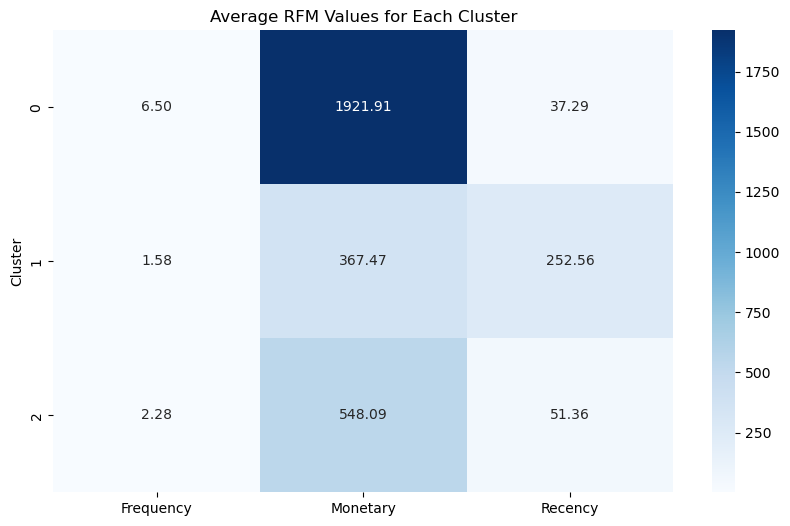

In [276]:
# Heatmap for Cluster Analysis
heatmap_data = non_outliers_df.pivot_table(index='Cluster', values=['Recency', 'Frequency', 'Monetary'], aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f')
plt.title('Average RFM Values for Each Cluster')
plt.show()


***Finding solutions to Questions***

2.2 Distribution of number of orders per customer.

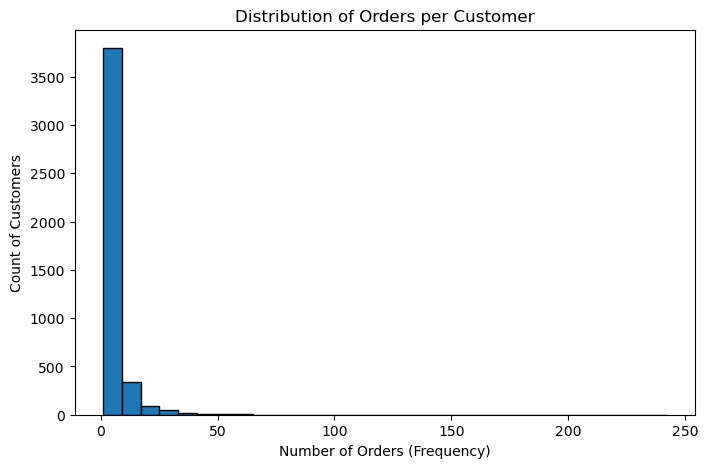

In [277]:
import matplotlib.pyplot as plt

# Plot distribution of Frequency (number of orders per customer)
plt.figure(figsize=(8, 5))
plt.hist(rfm_df['Frequency'], bins=30, edgecolor='black')  
plt.xlabel('Number of Orders (Frequency)')
plt.ylabel('Count of Customers')
plt.title('Distribution of Orders per Customer')
plt.show()


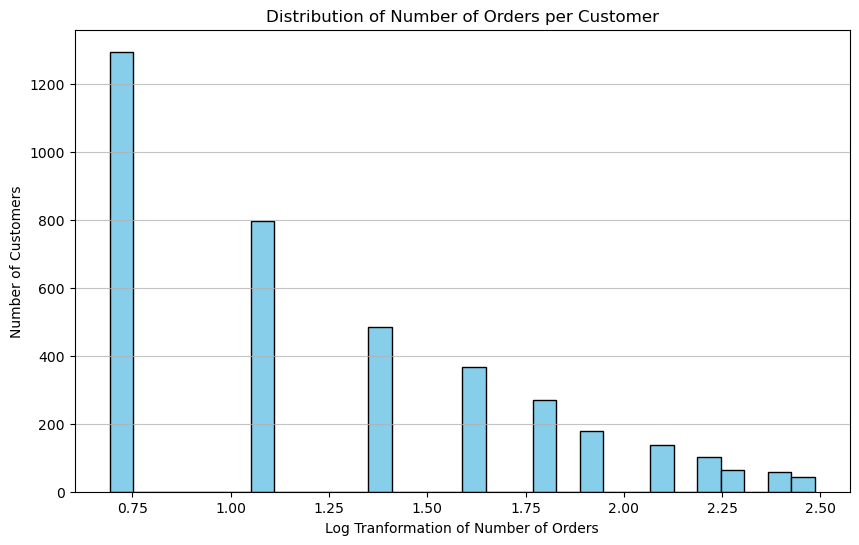

In [278]:
plt.figure(figsize=(10, 6))
plt.hist(rfm_log['Frequency'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Orders per Customer')
plt.xlabel('Log Tranformation of Number of Orders')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.75)

plt.show()

2.3 Top 5 Customers who made the most purchases

In [280]:
topCustomers = rfm_df.sort_values(by='Frequency', ascending=False).head(5)
topCustomers.head()

CustomerID  Recency  Frequency  Monetary       LastInvoiceDt
1891    14911.00        0        242 128882.13 2011-12-08 15:54:00
328     12748.00        0        217  30486.53 2011-12-09 12:20:00
4033    17841.00        1        169  40333.22 2011-12-08 12:07:00
1670    14606.00        0        125  11567.10 2011-12-08 19:28:00
2188    15311.00        0        118  59419.34 2011-12-09 12:00:00

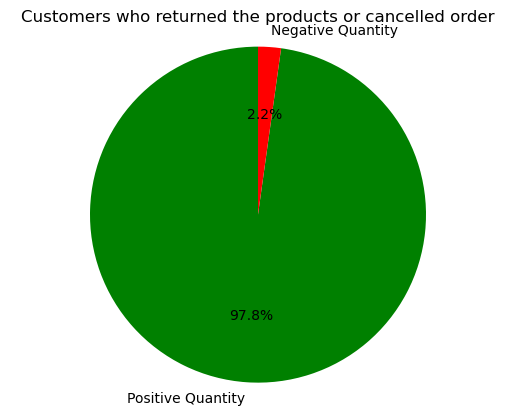

In [281]:
# Calculate the counts of customers with positive and negative quantities
positive_quantity_count = len(clean_df[clean_df['Quantity'] > 0])
negative_quantity_count = len(cancelled_order)

# Create labels and values for the pie chart
labels = ['Positive Quantity', 'Negative Quantity']
values = [positive_quantity_count, negative_quantity_count]

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Customers who returned the products or cancelled order')

plt.show()


**3 PRODUCT ANALYSIS**

3.1 What are the top 10 most frequently purchased products

In [282]:
top_products = clean_df['Description'].value_counts().head(10)
top_products.head()

Description
WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1904
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1415
Name: count, dtype: int64

3.2 Average price of products in the dataset

In [283]:
avg_price= clean_df['UnitPrice'].sum()/clean_df['StockCode'].nunique()
print(f"{avg_price:.2f}")  

319.56


3.3 Product Category generating highest revenue

In [284]:
maxrev_df = clean_df.groupby(['StockCode', 'Description'])['SalesTotal'].sum().reset_index()
maxrev_df = maxrev_df.sort_values("SalesTotal", ascending=False)  # Correct sorting
maxrev_df.head()  

StockCode                         Description  SalesTotal
1322     22423            REGENCY CAKESTAND 3 TIER   132870.40
3475    85123A  WHITE HANGING HEART T-LIGHT HOLDER    93823.85
3460    85099B             JUMBO BAG RED RETROSPOT    83236.76
2805     47566                       PARTY BUNTING    67687.53
3288     84879       ASSORTED COLOUR BIRD ORNAMENT    56499.22

In [285]:
max_rev= maxrev_df.loc[maxrev_df['SalesTotal'].idxmax(), 'Description']
max_rev

'REGENCY CAKESTAND 3 TIER'

**4. TIME ANALYSIS**

4.1 Is there a specific day of the week or time of day when most orders are placed?

In [286]:
clean_df['InvoiceDate'] = pd.to_datetime(clean_df['InvoiceDate'], format='%Y/%m/%d')

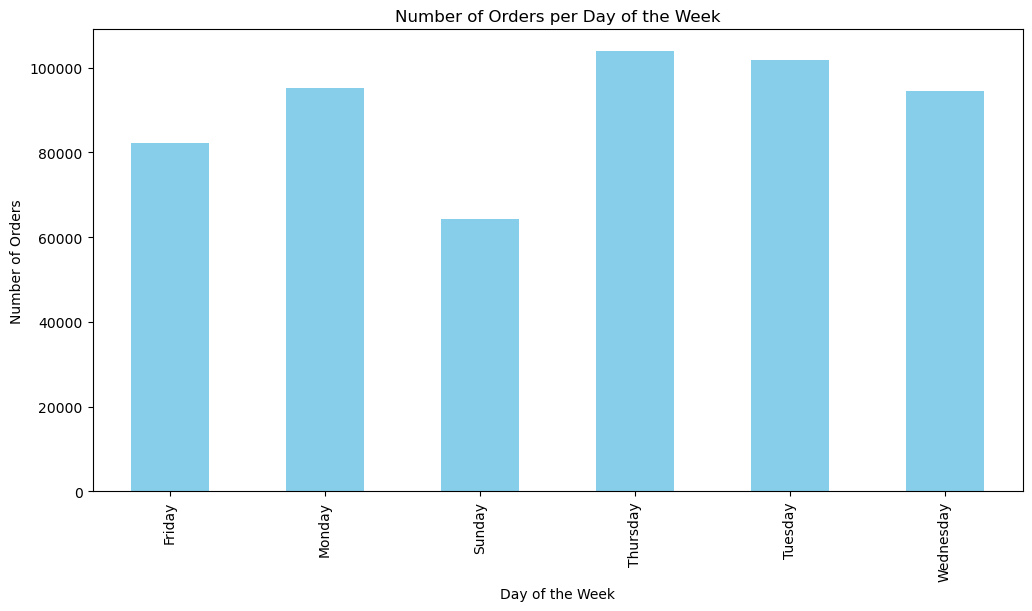

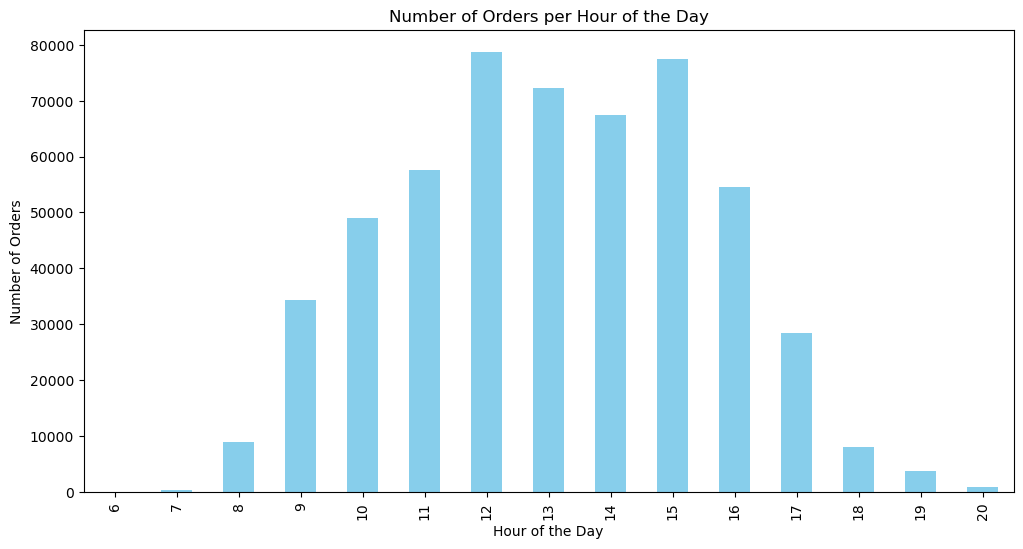

In [287]:
customer['DayOfWeek'] = customer['InvoiceDate'].dt.day_name()
customer['HourOfDay'] = customer['InvoiceDate'].dt.hour
plt.figure(figsize=(12, 6))
customer.groupby('DayOfWeek')['InvoiceNo'].count().plot(kind='bar', color='skyblue')
plt.title('Number of Orders per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.show(
)

# Plot the number of orders per hour of the day
plt.figure(figsize=(12, 6))
customer.groupby('HourOfDay')['InvoiceNo'].count().plot(kind='bar', color='skyblue')
plt.title('Number of Orders per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.show()

4.2  What is the average order processing time?

As there is no relevant column for the same, the average order processing can't be calculated. However, if a feature mentioning the order confirmation time is present, it can be calculated for every record

4.3 Are there any seasonal trends in the dataset?

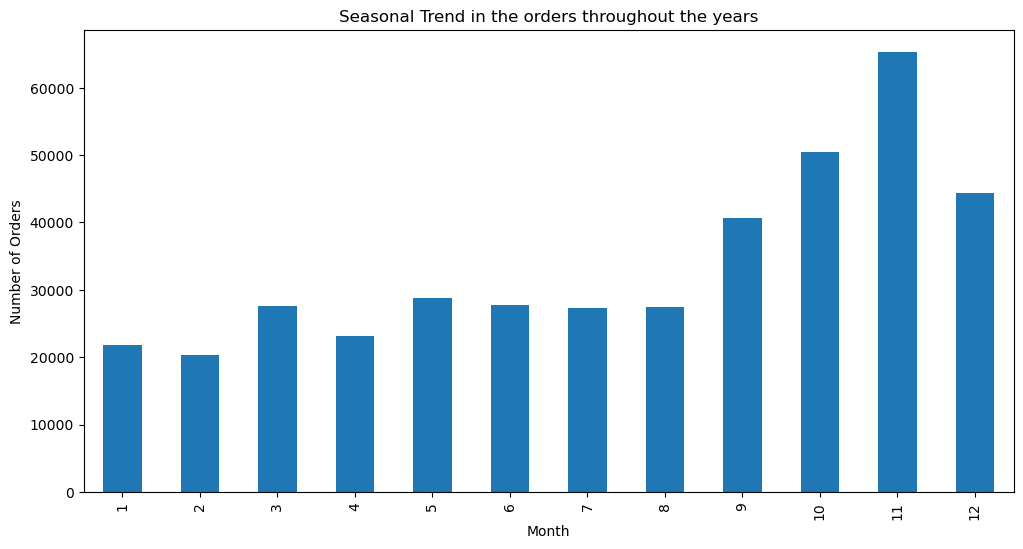

In [291]:
clean_df['Month'] = clean_df['InvoiceDate'].dt.month
plt.figure(figsize=(12, 6))
clean_df.groupby('Month')['InvoiceNo'].count().plot(kind='bar' )
plt.title('Seasonal Trend in the orders throughout the years')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

The shopping trend increases around winters, or the holidays as people tend to buy gifts for their loved ones around the festivals

**5. GEOGRAPHICAL ANALYSIS**

5.1 Top 5 countries with the highest number of orders

In [292]:
top_countries=  clean_df['Country'].value_counts().head(5)
top_countries

Country
United Kingdom    361235
Germany             9095
France              8168
EIRE                7378
Spain               2467
Name: count, dtype: int64

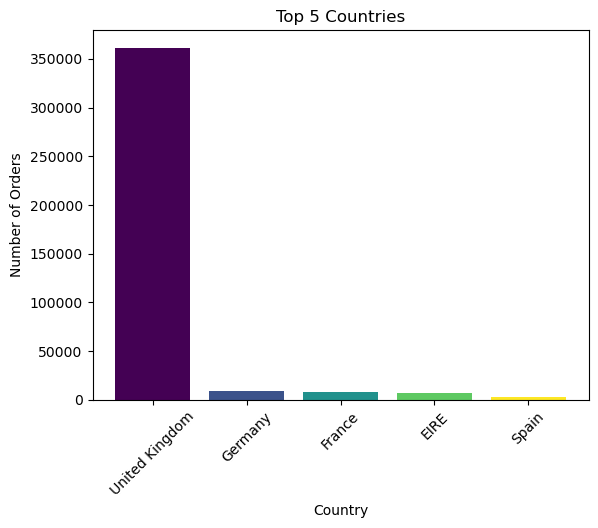

In [293]:
colors = plt.cm.viridis(np.linspace(0, 1, len(top_countries)))

# Create the bar chart
plt.bar(top_countries.index, top_countries, color=colors)

# Add labels and title
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.title('Top 5 Countries')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

5.2 correlation between the country of the customer and the average order
value

C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


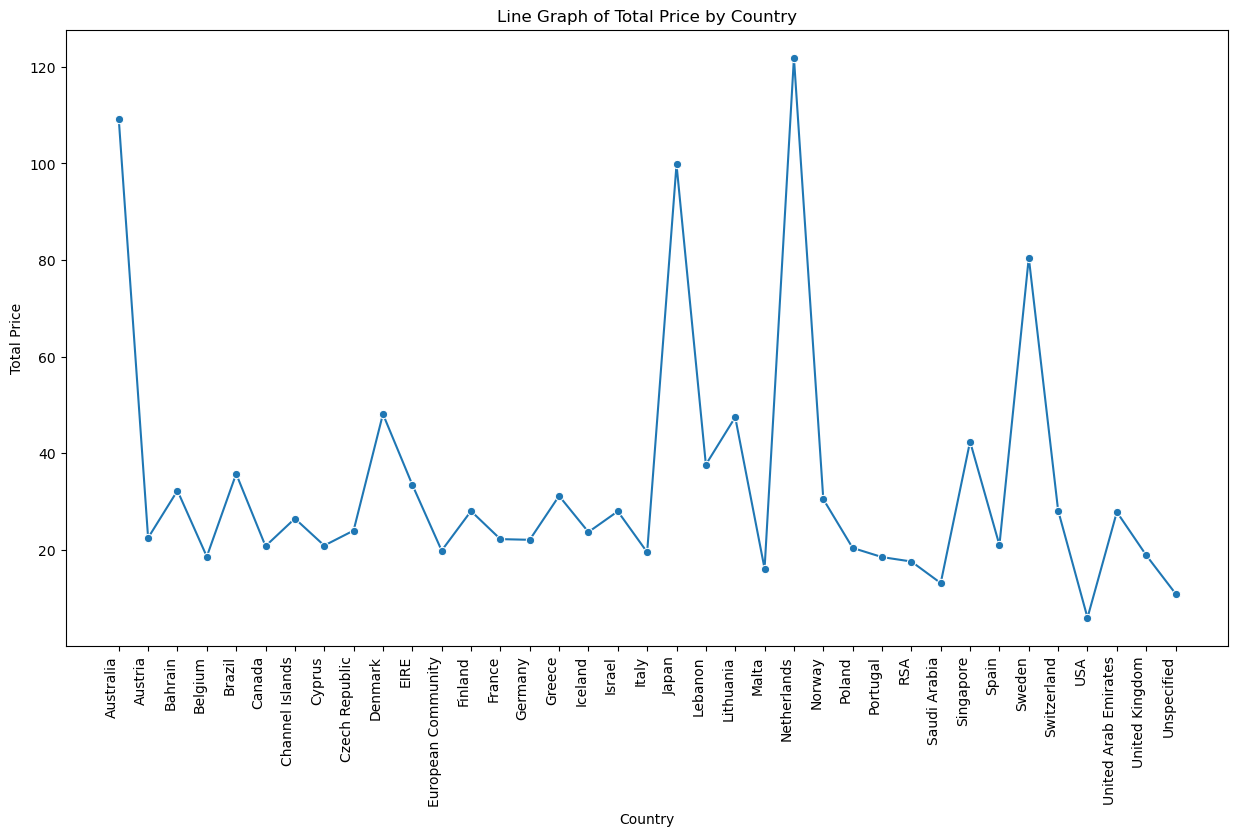

In [294]:
avg_order_country = clean_df.groupby('Country')['SalesTotal'].mean().reset_index()

# Check the correlation with line graph
plt.figure(figsize=(15, 8))
sns.lineplot(x='Country', y='SalesTotal', data=avg_order_country, marker='o')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

plt.xlabel('Country')
plt.ylabel('Total Price')
plt.title('Line Graph of Total Price by Country')

# Show the plot
plt.show()


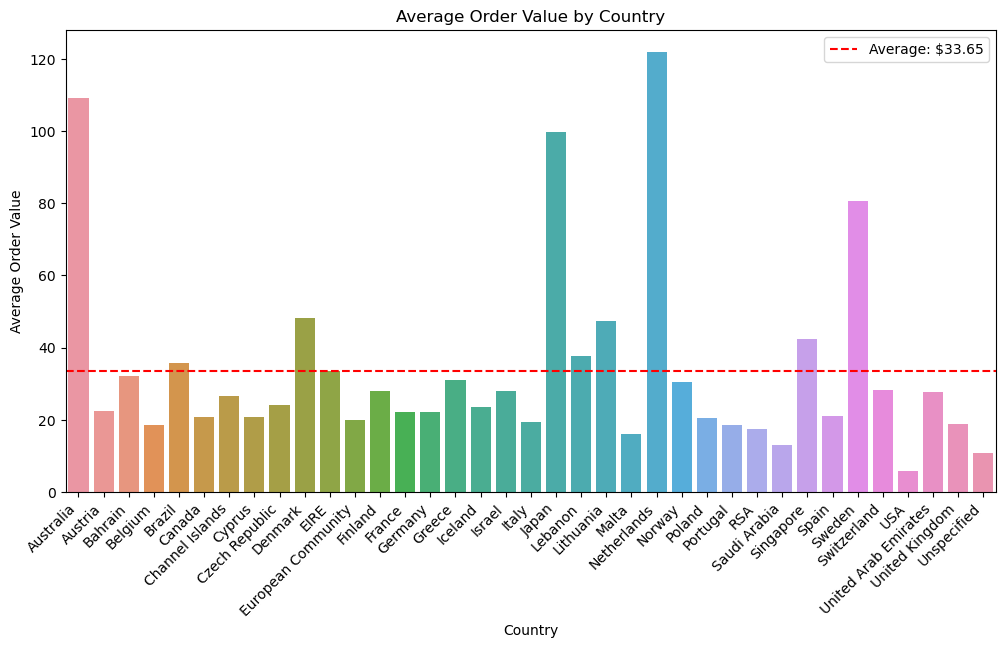

In [295]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='SalesTotal', data=avg_order_country)

# Add average markings to the plot
avg_ref = avg_order_country['SalesTotal'].mean()
plt.axhline(y=avg_ref, color='r', linestyle='--', label=f'Average: ${avg_ref:.2f}')

# Add labels and title
plt.title('Average Order Value by Country')
plt.xlabel('Country')
plt.ylabel('Average Order Value')

# Rotate country labels for better readability
plt.xticks(rotation=45, ha='right')

# Show legend
plt.legend()

plt.show()


**6. Payment Analysis**

In [297]:
import random
payment= ['VISA', 'Master Card', 'Apple Pay', 'American Express', 'Discover', 'Google Pay', 'Paypal']
random.seed(0)
clean_df['Mode of Payment']= np.random.choice(payment, size= len(clean_df))
clean_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  SalesTotal  \
0 2010-12-01 08:26:00       2.55    17850.00  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39    17850.00  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75    17850.00  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39    17850.00  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39    17850.00  United Kingdom       20.34   

   Month Mode of Payment  
0     12      Google Pay  
1     12      Google Pay  
2     12      Google Pay  
3     12            VISA  
4     12          Paypal

In [298]:
top_payment=  clean_df['Mode of Payment'].value_counts().head(5)
top_payment

Mode of Payment
Paypal              58114
Discover            58095
American Express    57888
VISA                57886
Master Card         57746
Name: count, dtype: int64

In [301]:
payment = clean_df.groupby('Mode of Payment')['SalesTotal'].sum().reindex(top_payment.index)
payment

Mode of Payment
Paypal             1189724.39
Discover           1346537.85
American Express   1171734.49
VISA               1197657.28
Master Card         980101.03
Name: SalesTotal, dtype: float64

6.2 Relationship between the payment method and the order amount

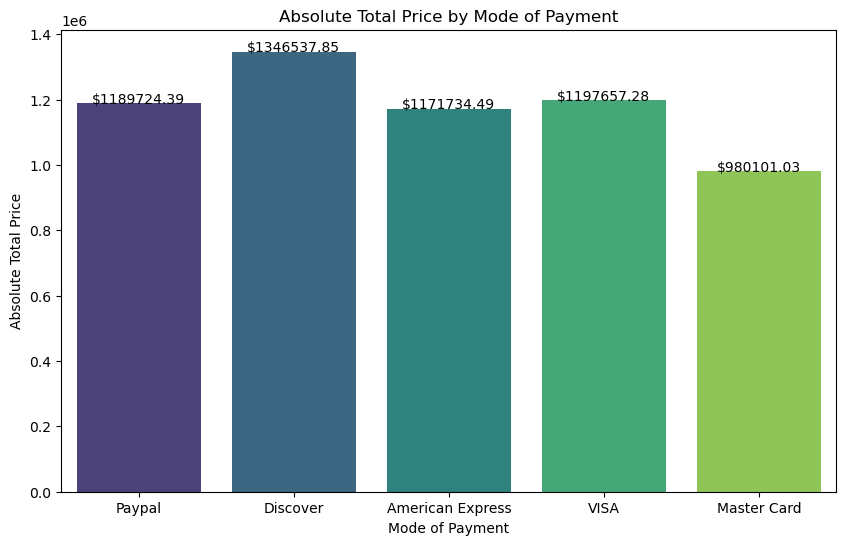

In [302]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=payment.index, y=payment.values, palette='viridis')
bar_plot.set_xlabel('Mode of Payment')
bar_plot.set_ylabel('Absolute Total Price')
bar_plot.set_title('Absolute Total Price by Mode of Payment')

# Add values on top of each bar
for i, v in enumerate(payment.values):
    plt.text(i, v + 50, f'${v:.2f}', ha='center')
plt.show()


As seen from the sample data generated for mode of payment, there doesn't seem to be any relation between the order amount and payment method

**7. Customer Behavior**

7.1 How long, on average, do customers remain active (between their first and last
purchase)?

In [303]:
customer_activity = clean_df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])

# Calculate the duration of activity for each customer
customer_activity['Duration'] = customer_activity['max'] - customer_activity['min']

# Calculate the average duration across all customers
average_duration = customer_activity['Duration'].mean()

print(f"Average Duration of Customer Activity: {average_duration}")

Average Duration of Customer Activity: 133 days 13:41:17.634112792


7.2 customer segments based on their purchase behavior

The customer segments based on purchase behavior are

*   High-Value and Recently Active Customers
*   Regular but Less Recent Customers
*   High-Frequency but Lower Monetary Value
*   Infrequent and Low-Value Customers





**8. RETURNS AND REFUNDS**

8.1 What is the percentage of orders that have experienced returns or refunds?

In [310]:
# neg_quant= customer[customer['Quantity']<0]
print("percentage of orders that have experienced returns or refunds: ", len(cancelled_order)/len(clean_df)*100, "%")

percentage of orders that have experienced returns or refunds:  2.199438840533892 %


8.2 Is there a correlation between the product category and the likelihood of returns?

C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mansi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


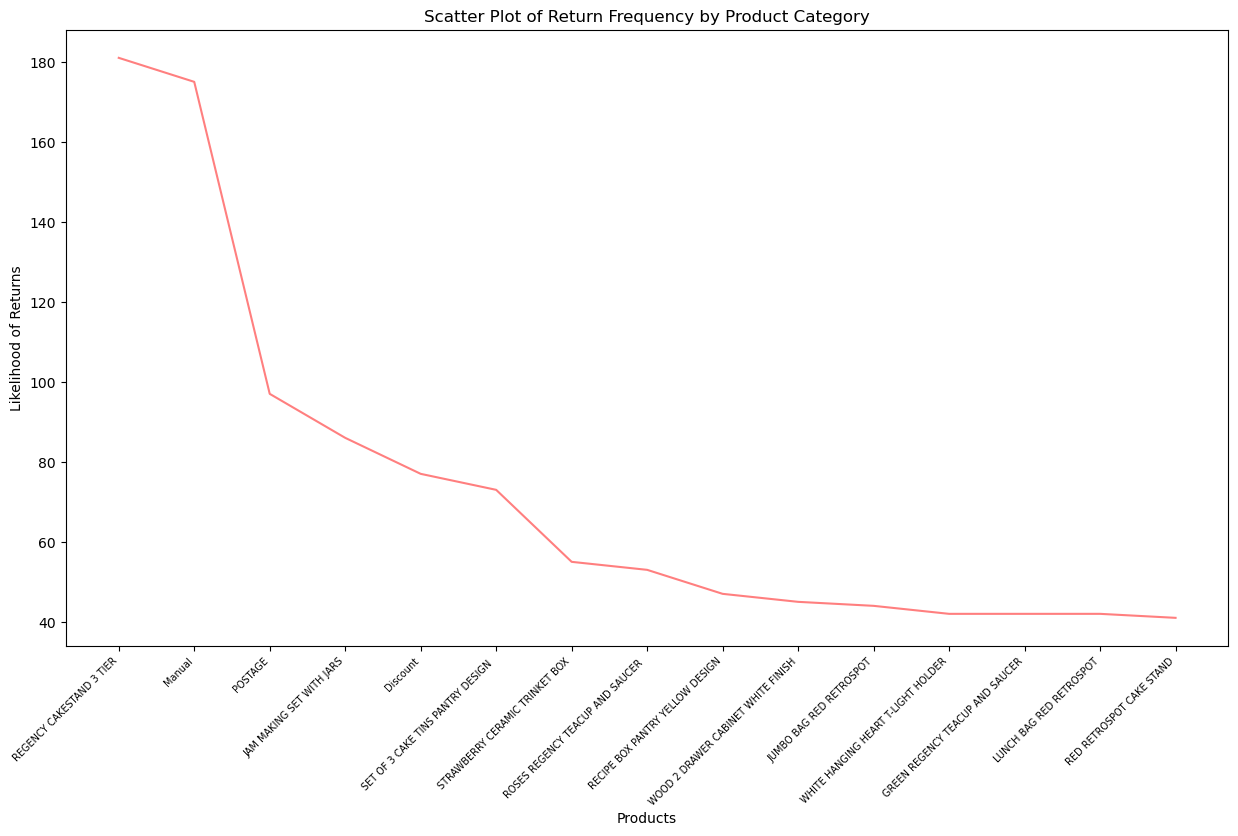

In [312]:
neg_df = cancelled_order.groupby('Description').size().reset_index()
neg_df.columns = ['Description', 'Return Frequency']
neg_df = neg_df.sort_values(by='Return Frequency', ascending=False).head(15)



plt.figure(figsize=(15, 8))
sns.lineplot(x='Description', y='Return Frequency', data=neg_df, alpha=0.5, color='red')
plt.xticks(rotation=45, ha='right', fontsize=7)

plt.xlabel('Products')
plt.ylabel('Likelihood of Returns')
plt.title('Scatter Plot of Return Frequency by Product Category')
plt.show()


**Predicting Customer buying pattern for next 2 months**

<Axes: title={'center': 'Monthly Spending for Customer 14911'}, xlabel='Date'>

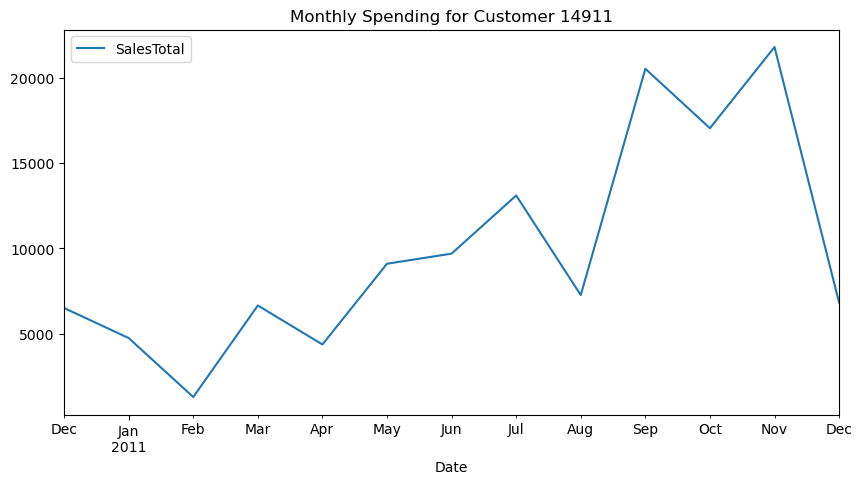

In [321]:
customer_id = 14911.00  

# Filter and aggregate by month
cust_df = clean_df[clean_df['CustomerID'] == customer_id]
cust_monthly = (
    cust_df.groupby(cust_df['InvoiceDate'].dt.to_period("M"))['SalesTotal']
    .sum()
    .reset_index()
)
cust_monthly.columns = ["Date", "SalesTotal"]
cust_monthly['Date'] = cust_monthly['Date'].dt.to_timestamp()
cust_monthly.set_index('Date', inplace=True)

# Visualize the series
cust_monthly.plot(title=f"Monthly Spending for Customer {int(customer_id)}", figsize=(10, 5))

In [325]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, title=''):
    print(f'ADF Test for {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    for val, label in zip(result, labels):
        print(f"{label} : {val}")
    if result[1] <= 0.05:
        print("Stationary: Reject null (no unit root)")
    else:
        print("Non-stationary: Cannot reject null (unit root present)")
    print('-'*50)

adfuller_test(cust_monthly['SalesTotal'], title=f'Customer {int(customer_id)} Original Series')


ADF Test for Customer 14911 Original Series
ADF Statistic : 0.2065437401353036
p-value : 0.9726262333893219
# Lags Used : 3
Number of Observations Used : 9
Non-stationary: Cannot reject null (unit root present)
--------------------------------------------------


In [326]:
cust_monthly['First Diff'] = cust_monthly['SalesTotal'] - cust_monthly['SalesTotal'].shift(1)


In [327]:
adfuller_test(cust_monthly['First Diff'], title='First Difference')


ADF Test for First Difference
ADF Statistic : -2.876533800327128
p-value : 0.04814563834986681
# Lags Used : 3
Number of Observations Used : 8
Stationary: Reject null (no unit root)
--------------------------------------------------


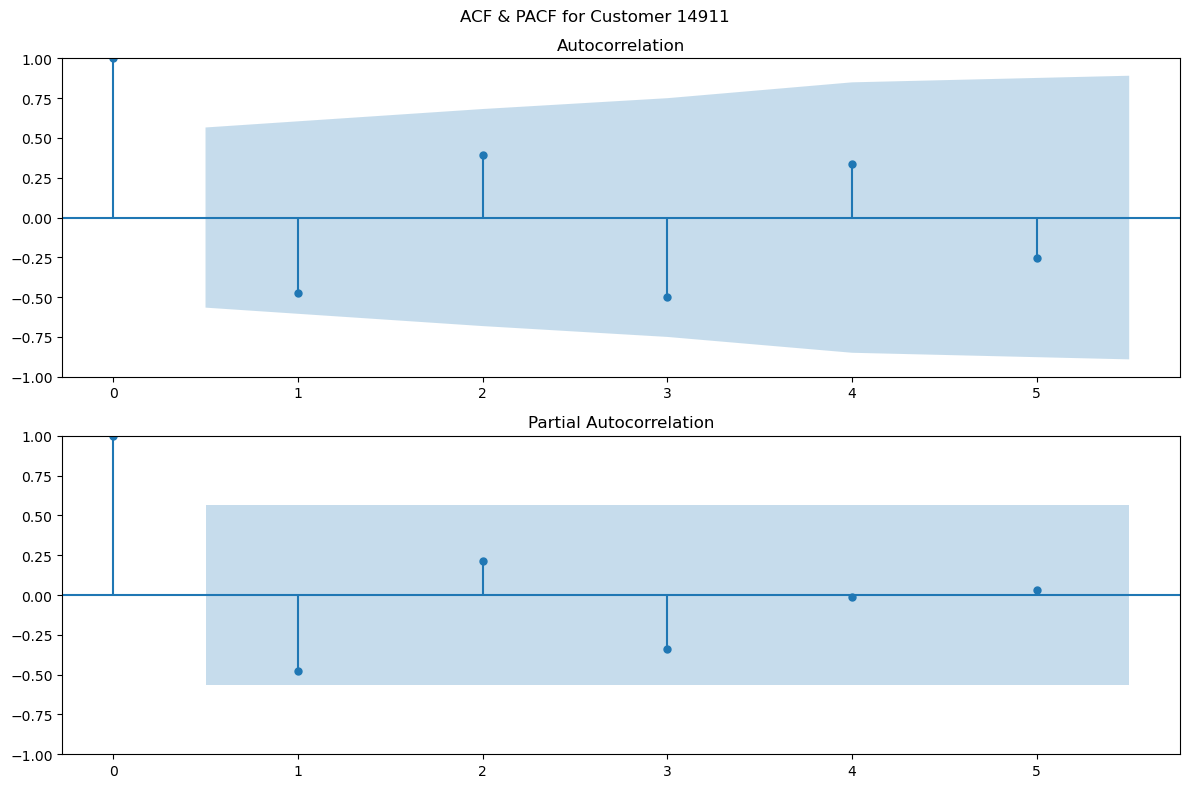

In [331]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(cust_monthly['First Diff'].dropna(), lags=5, ax=ax[0])
sm.graphics.tsa.plot_pacf(cust_monthly['First Diff'].dropna(), lags=5, ax=ax[1])
plt.suptitle(f'ACF & PACF for Customer {int(customer_id)}')
plt.tight_layout()
plt.show()


C:\Users\mansi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mansi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mansi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mansi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mansi\AppData\Local\Temp\ipykernel_25016\3843555838.py:11: FutureWarning: 'M' is deprecated an

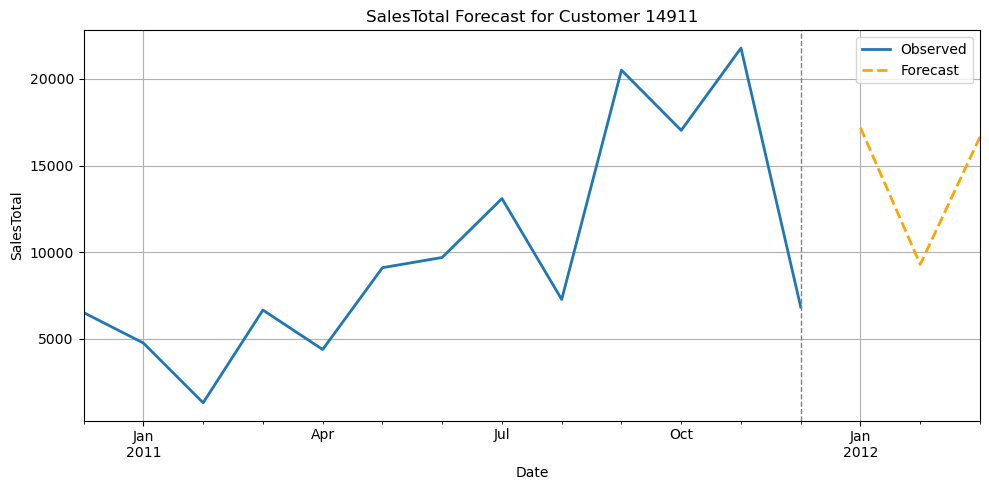

In [341]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd

# Fit SARIMAX model
model = SARIMAX(cust_monthly['SalesTotal'], order=(1,1,2))
result = model.fit(disp=False)

# Forecast next 2 months
forecast = result.get_forecast(steps=3)
forecast_index = pd.date_range(start=cust_monthly.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')
forecast_df = pd.DataFrame({'Forecast': forecast.predicted_mean.values}, index=forecast_index)

# Plot actual + forecast on the same figure
plt.figure(figsize=(10, 5))

# Plot observed (historical) data
cust_monthly['SalesTotal'].plot(label='Observed', linestyle='-', linewidth=2)

# Plot forecast
forecast_df['Forecast'].plot(label='Forecast', linestyle='--', linewidth=2, color='orange')

# Optional: visual separator between observed and forecast
plt.axvline(x=cust_monthly.index[-1], color='gray', linestyle='--', linewidth=1)

# Plot styling
plt.title(f"SalesTotal Forecast for Customer {int(customer_id)}")
plt.xlabel('Date')
plt.ylabel('SalesTotal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
